In [41]:
import torch
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from aging.size_norm.data import Session
from aging.size_norm.lightning import predict
from aging.plotting import figure, legend
from kornia.geometry.transform import scale

In [3]:
model_path = '/home/wg41/groups/win/longtogeny/size_norm/models/pre_final_model-2023-09-30_v00/model.pt'

In [4]:
folder = Path("/n/groups/datta/Dana/Ontogeny/raw_data/Dana_ontogeny/Males/3months_19042021")
# load input data
depth_files = sorted(folder.glob("**/results_00.h5"))

frames = []
for file in depth_files[:1]:
    with h5py.File(file, 'r') as f:
        frames.append(f['frames'][()][::2])
frames = np.concatenate(frames, axis=0)

In [5]:
test_frame = frames[100]

In [6]:
test_frame_array = [frames[100], frames[500], frames[1110], frames[1810], frames[1910], frames[2010], frames[2400], frames[2600]]

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
mdl = torch.jit.load(model_path, map_location=device).eval()

In [7]:
scales = np.linspace(0.1, 1.9, 38)
batch = np.tile(test_frame, (len(scales), 1, 1, 1))

In [8]:
comparison = predict(Session(test_frame[None]), mdl, batch_size=1)

  0%|          | 0/1 [00:00<?, ?it/s]

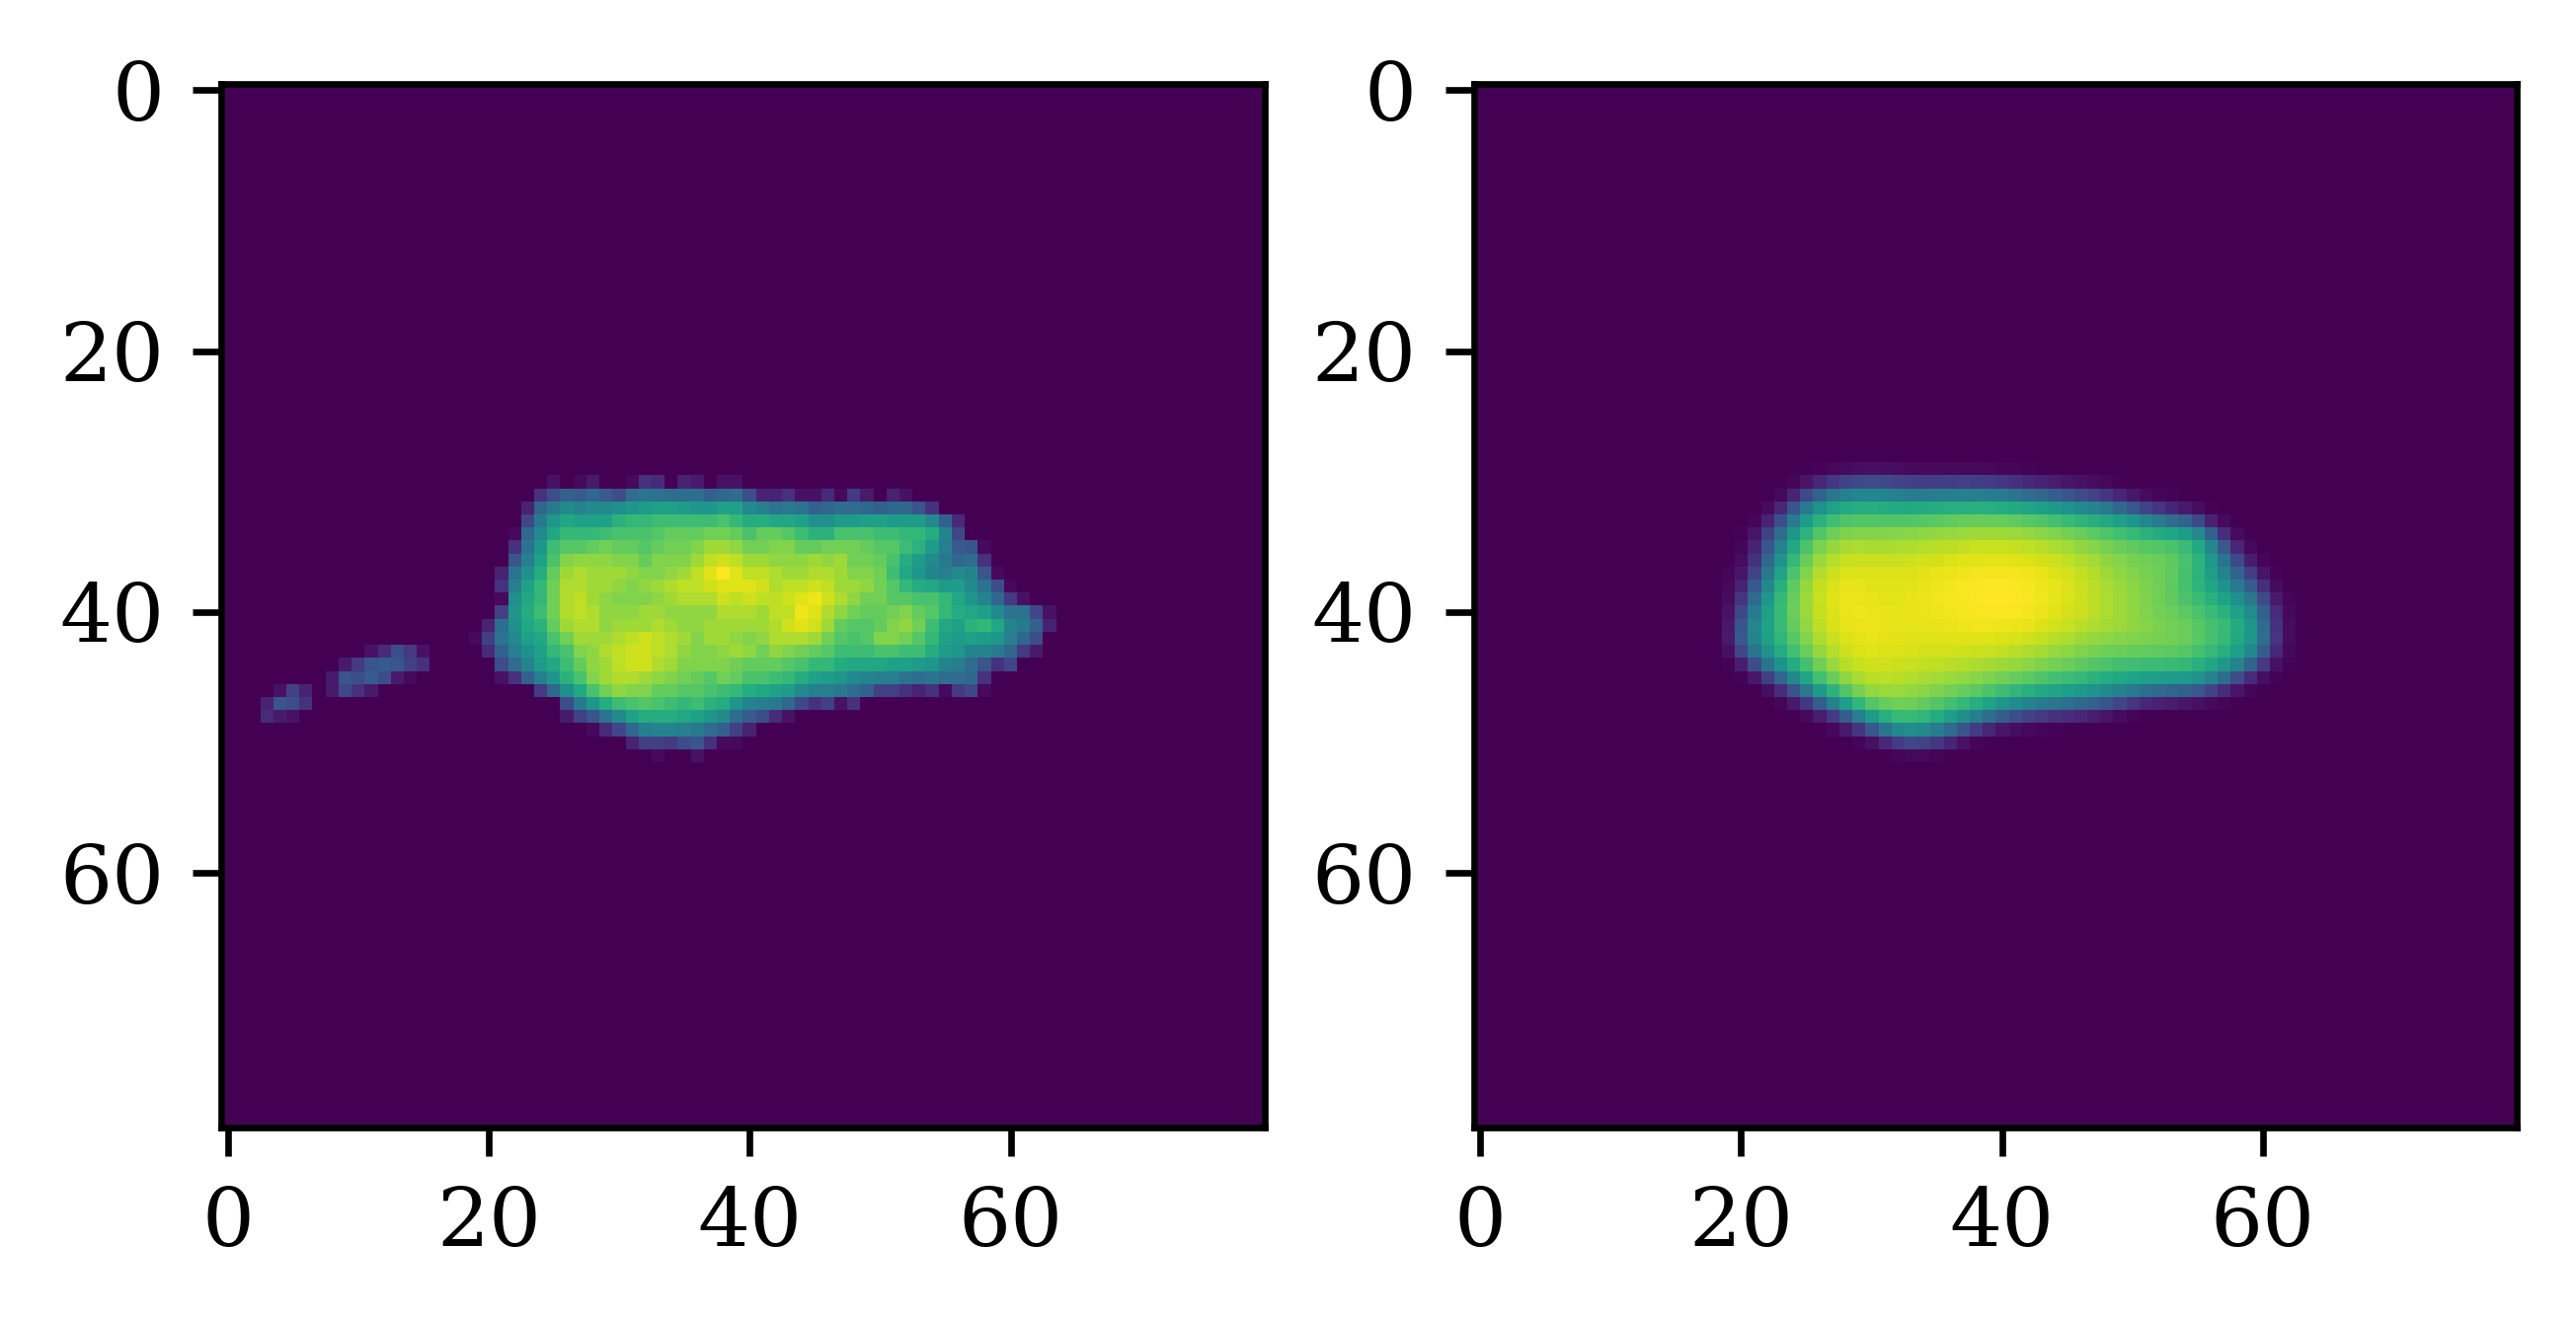

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2.5))
ax[0].imshow(test_frame)
ax[1].imshow(comparison)

In [10]:
resized = scale(torch.tensor(batch, dtype=torch.float32), torch.tensor([scales, scales], dtype=torch.float32).T)
resized_output = predict(Session(resized.squeeze().numpy()), mdl, batch_size=len(resized))

/tmp/ipykernel_23772/2191908801.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  resized = scale(torch.tensor(batch, dtype=torch.float32), torch.tensor([scales, scales], dtype=torch.float32).T)


  0%|          | 0/1 [00:00<?, ?it/s]

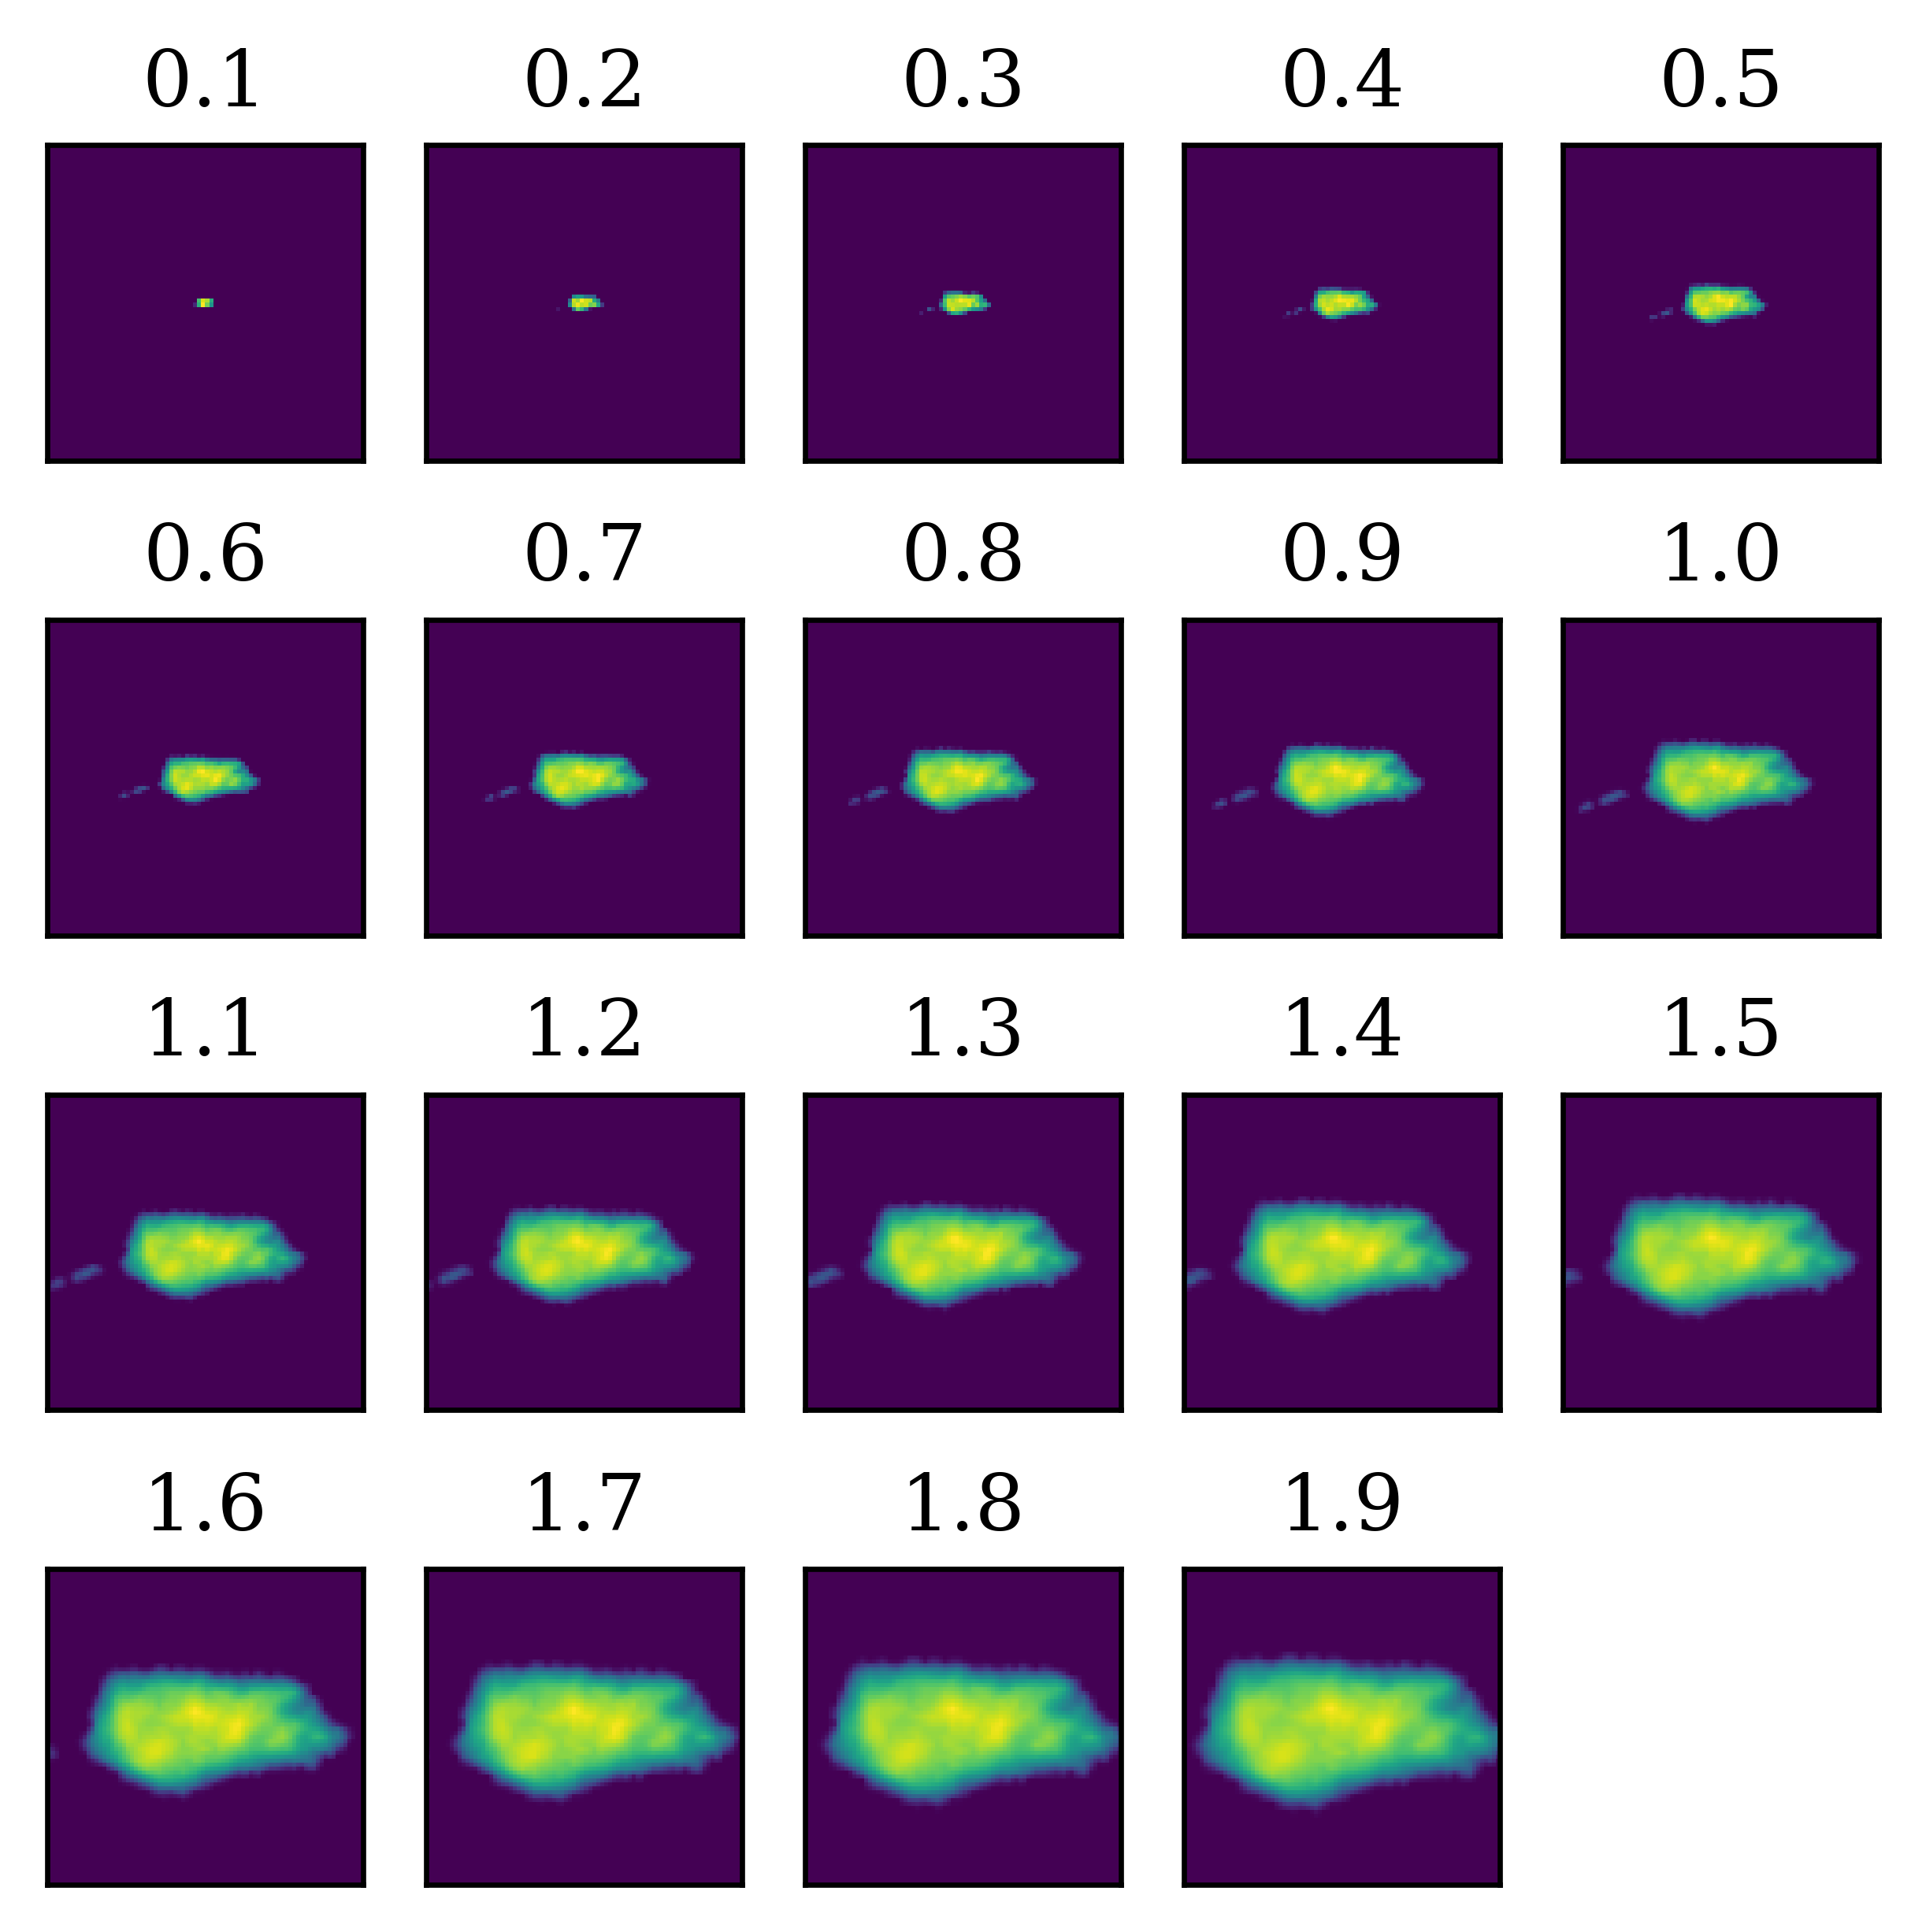

In [11]:
fig, ax = plt.subplots(4, 5, figsize=(5, 5))

for a, im, size in zip(ax.flat, resized[::2], scales[::2]):
    a.imshow(im.squeeze())
    a.set(title=round(size, 1), xticks=[], yticks=[])
ax.flatten()[-1].remove()


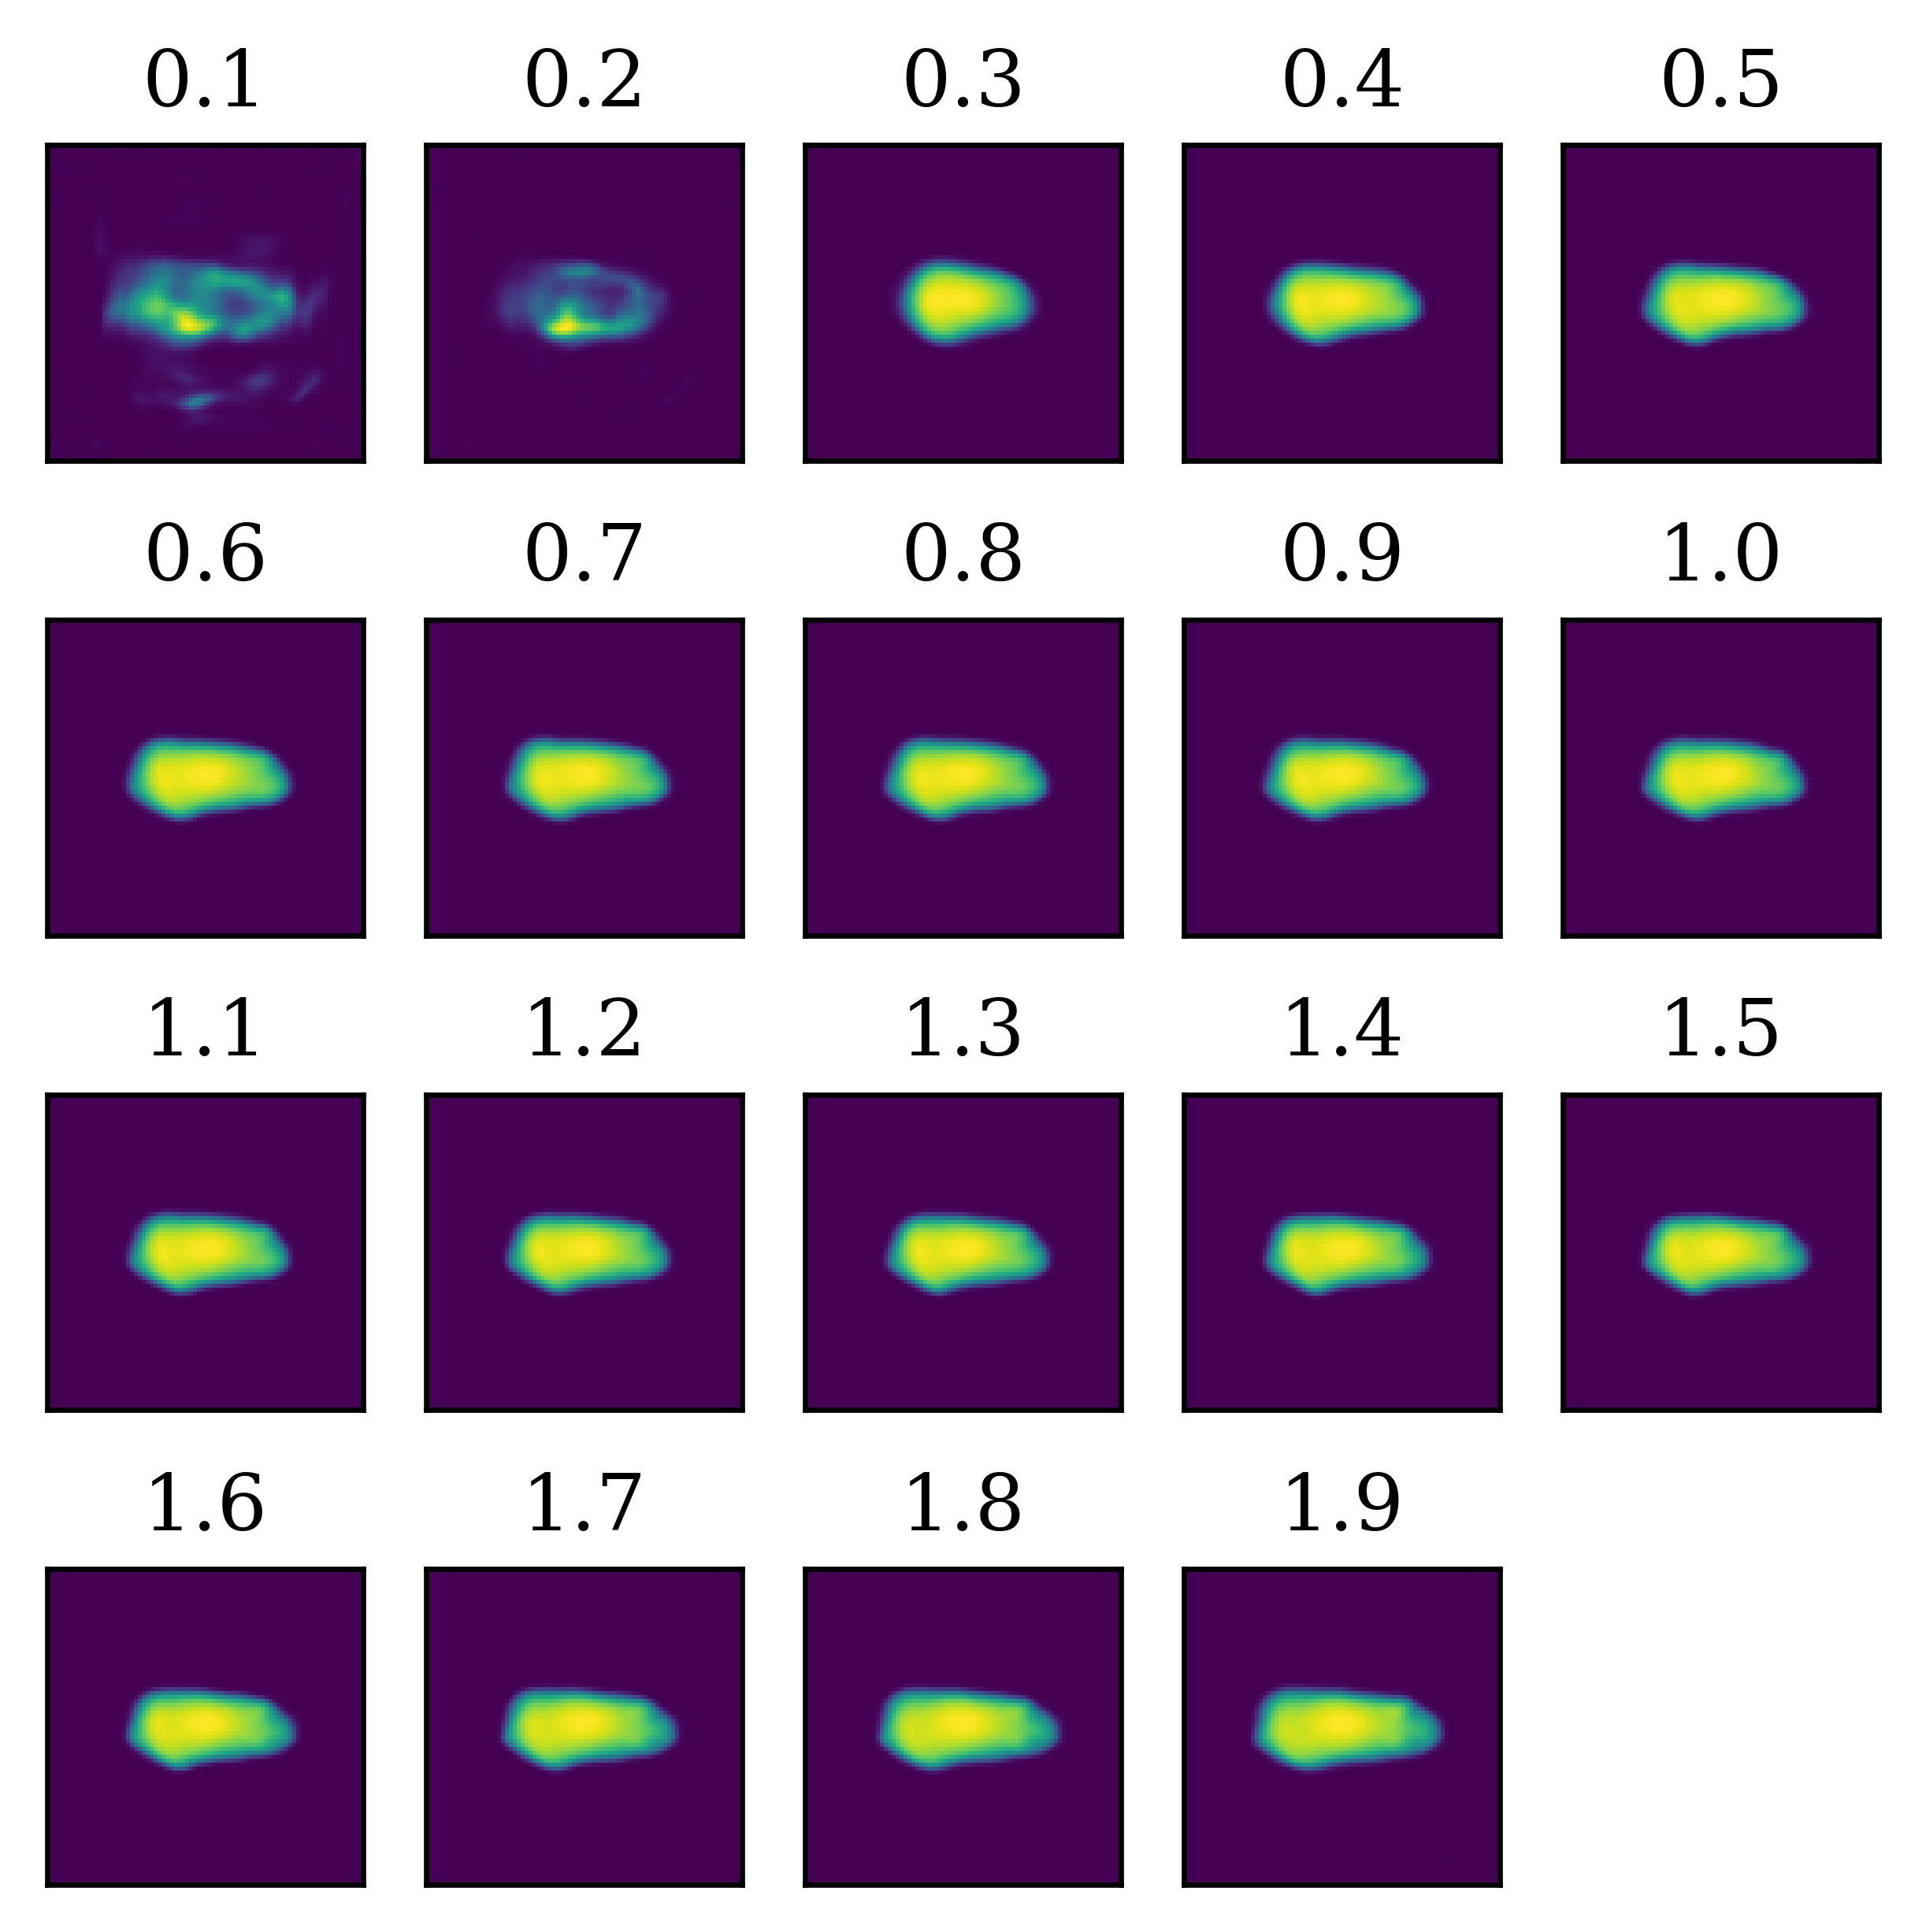

In [12]:
fig, ax = plt.subplots(4, 5, figsize=(5, 5))

for a, im, size in zip(ax.flat, resized_output[::2], scales[::2]):
    a.imshow(im)
    a.set(title=round(size, 1), xticks=[], yticks=[])
ax.flatten()[-1].remove()

In [13]:
squared_error = np.square(resized_output - comparison)
squared_error = np.mean(squared_error, axis=(1, 2))

(0.0, 5.0)

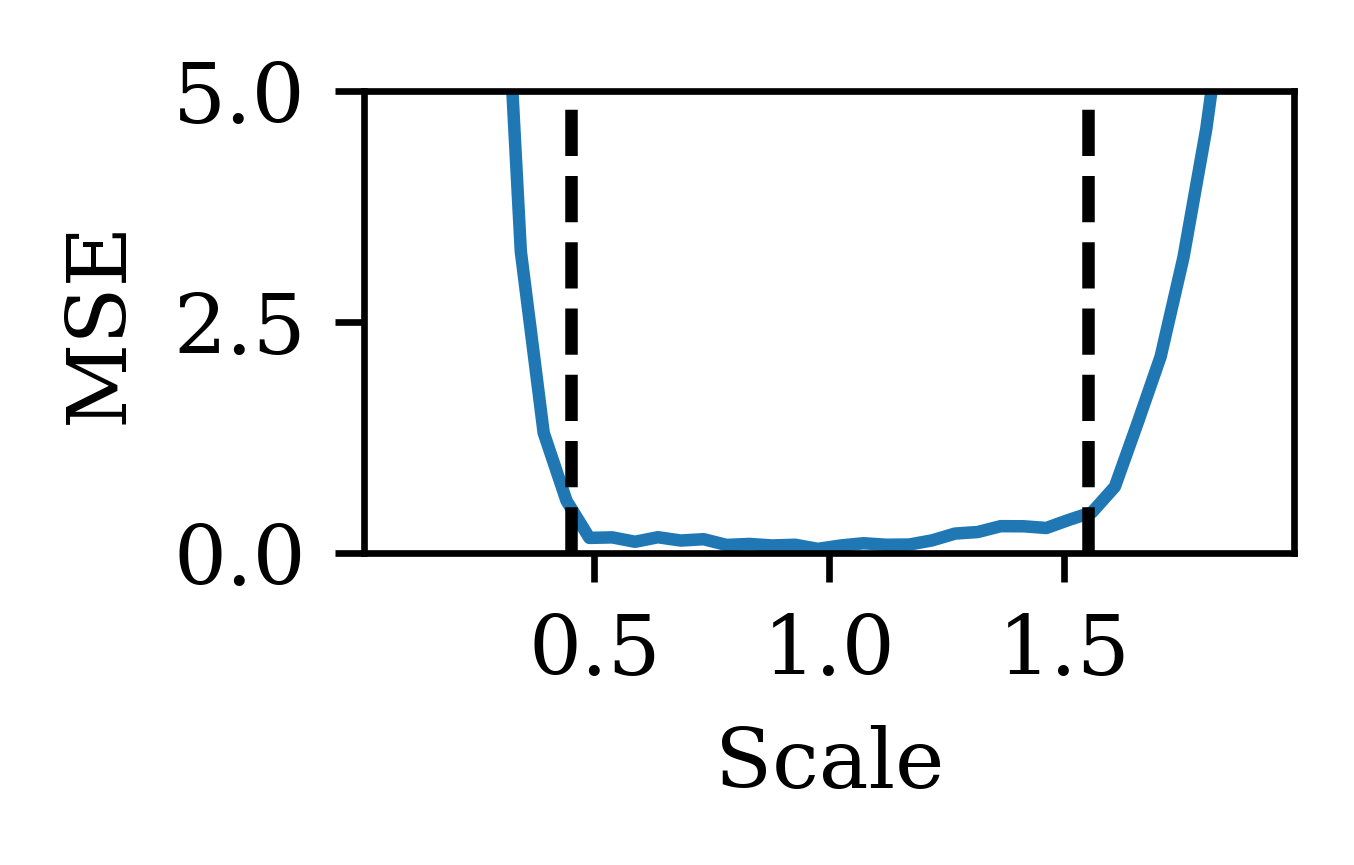

In [14]:
plt.figure(figsize=(2, 1))
plt.plot(scales, squared_error)
plt.ylabel("MSE")
plt.xlabel("Scale")
plt.axvline(0.45, color='k', linestyle='--')
plt.axvline(1.55, color='k', linestyle='--')
plt.ylim(0, 5)

In [15]:
resized = scale(torch.tensor(batch, dtype=torch.float32), torch.tensor([scales, np.ones(len(scales))], dtype=torch.float32).T)
resized_output = predict(Session(resized.squeeze().numpy()), mdl, batch_size=len(resized))

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
squared_error = np.square(resized_output - comparison)
squared_error = np.mean(squared_error, axis=(1, 2))

(0.0, 5.0)

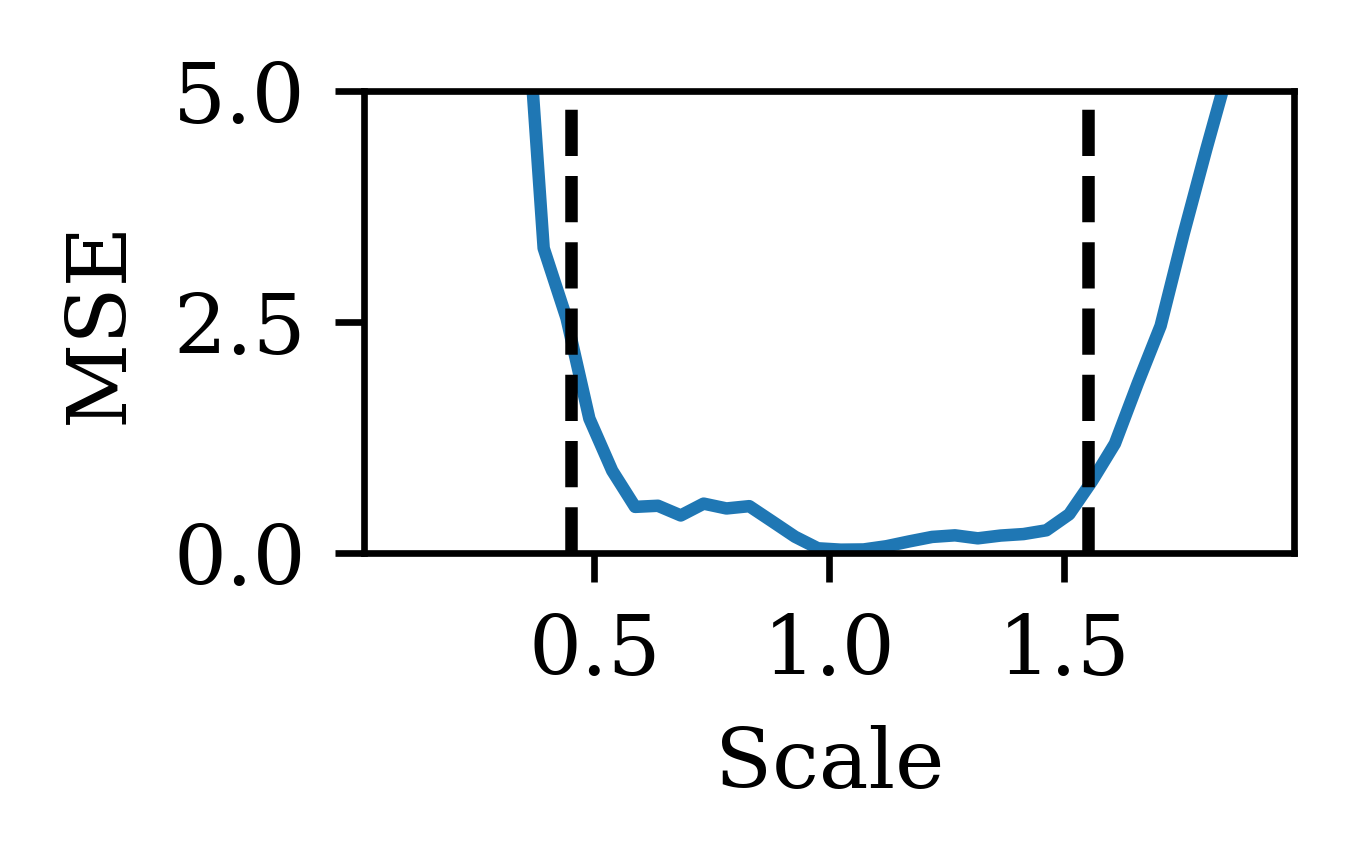

In [17]:
plt.figure(figsize=(2, 1))
plt.plot(scales, squared_error)
plt.ylabel("MSE")
plt.xlabel("Scale")
plt.axvline(0.45, color='k', linestyle='--')
plt.axvline(1.55, color='k', linestyle='--')
plt.ylim(0, 5)

In [18]:
resized = scale(torch.tensor(batch, dtype=torch.float32), torch.tensor([np.ones(len(scales)), scales], dtype=torch.float32).T)
resized_output = predict(Session(resized.squeeze().numpy()), mdl, batch_size=len(resized))

  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
squared_error = np.square(resized_output - comparison)
squared_error = np.mean(squared_error, axis=(1, 2))

(0.0, 5.0)

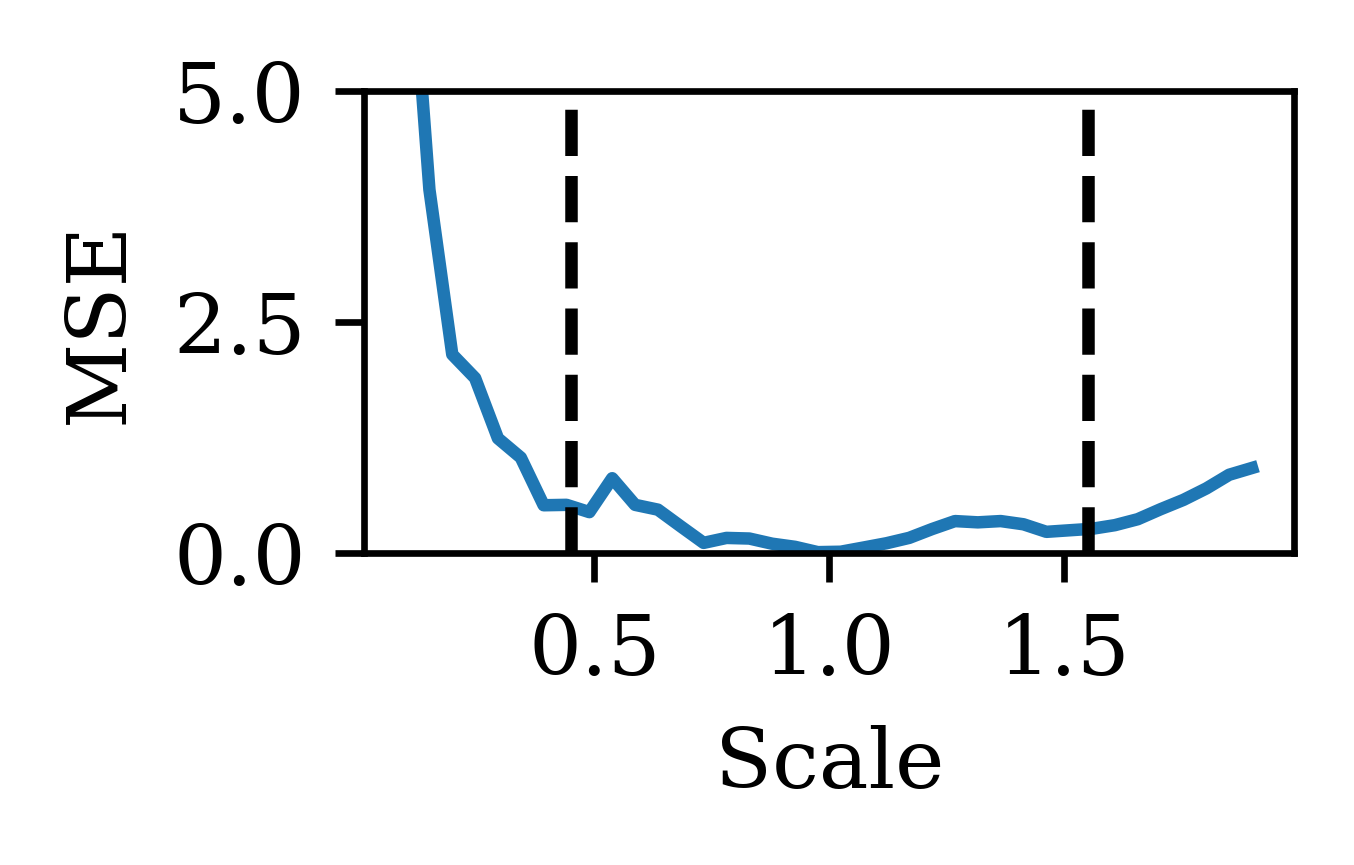

In [20]:
plt.figure(figsize=(2, 1))
plt.plot(scales, squared_error)
plt.ylabel("MSE")
plt.xlabel("Scale")
plt.axvline(0.45, color='k', linestyle='--')
plt.axvline(1.55, color='k', linestyle='--')
plt.ylim(0, 5)

In [21]:
mse = []
for s in scales:
    resized = scale(torch.tensor(batch, dtype=torch.float32), torch.tensor([np.ones(len(scales)) * s, scales], dtype=torch.float32).T)
    resized_output = predict(Session(resized.squeeze().numpy()), mdl, batch_size=len(resized), disable=True)
    squared_error = np.square(resized_output - comparison)
    squared_error = np.mean(squared_error, axis=(1, 2))
    mse.append(squared_error)
mse = np.array(mse)

mse_df = pd.DataFrame(mse, index=np.round(scales, 2), columns=np.round(scales, 2)).T
mse_df.index.name = "y scale"
mse_df.columns.name = "x scale"

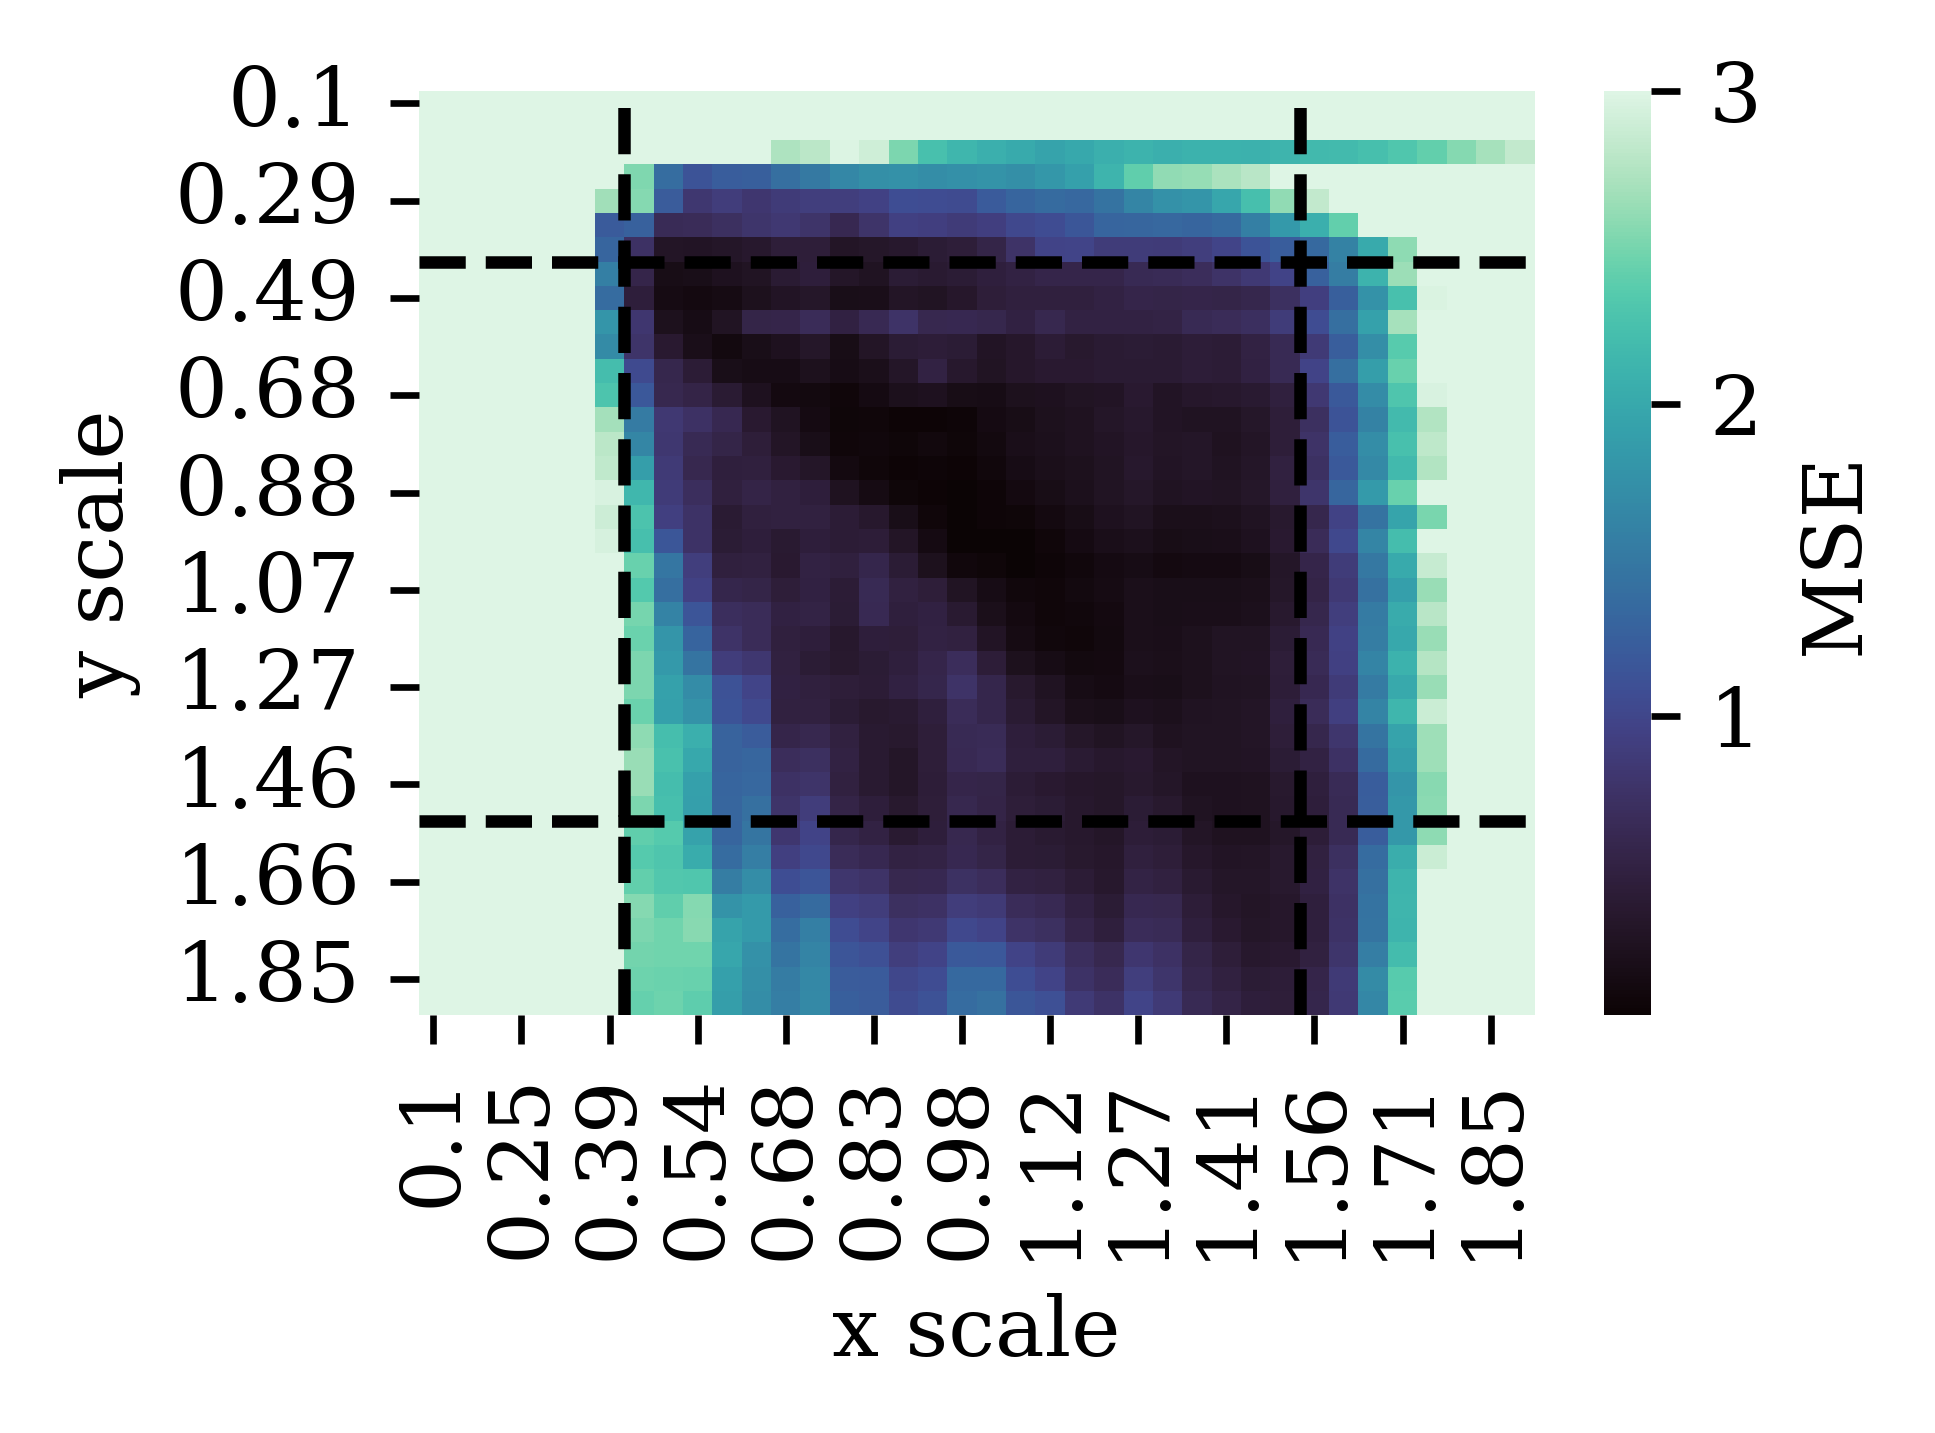

In [22]:
fig = figure(3, 2)
x1 = np.argmin(np.abs(scales - 0.45))
x2 = np.argmin(np.abs(scales - 1.55))
ax = sns.heatmap(mse_df, vmax=3, cmap='mako', cbar_kws={'label': 'MSE'})
ax.axhline(x1, color='k', linestyle='--')
ax.axhline(x2, color='k', linestyle='--')
ax.axvline(x1, color='k', linestyle='--')
ax.axvline(x2, color='k', linestyle='--')

## Go through all scales with different frames

In [23]:
all_mses = []
for frame in tqdm(test_frame_array):
    batch = np.tile(frame, (len(scales), 1, 1, 1))
    comparison = predict(Session(frame[None]), mdl, batch_size=1, disable=True)
    mse = []
    for s in scales:
        resized = scale(torch.tensor(batch, dtype=torch.float32), torch.tensor([np.ones(len(scales)) * s, scales], dtype=torch.float32).T)
        resized_output = predict(Session(resized.squeeze().numpy()), mdl, batch_size=len(resized), disable=True)
        squared_error = np.square(resized_output - comparison)
        squared_error = np.mean(squared_error, axis=(1, 2))
        mse.append(squared_error)
    mse = np.array(mse)
    all_mses.append(mse)

all_mses = np.array(all_mses)

all_mse_df = pd.DataFrame(np.mean(all_mses, axis=0), index=np.round(scales, 2), columns=np.round(scales, 2)).T
all_mse_df.index.name = "y scale"
all_mse_df.columns.name = "x scale"

  0%|          | 0/8 [00:00<?, ?it/s]

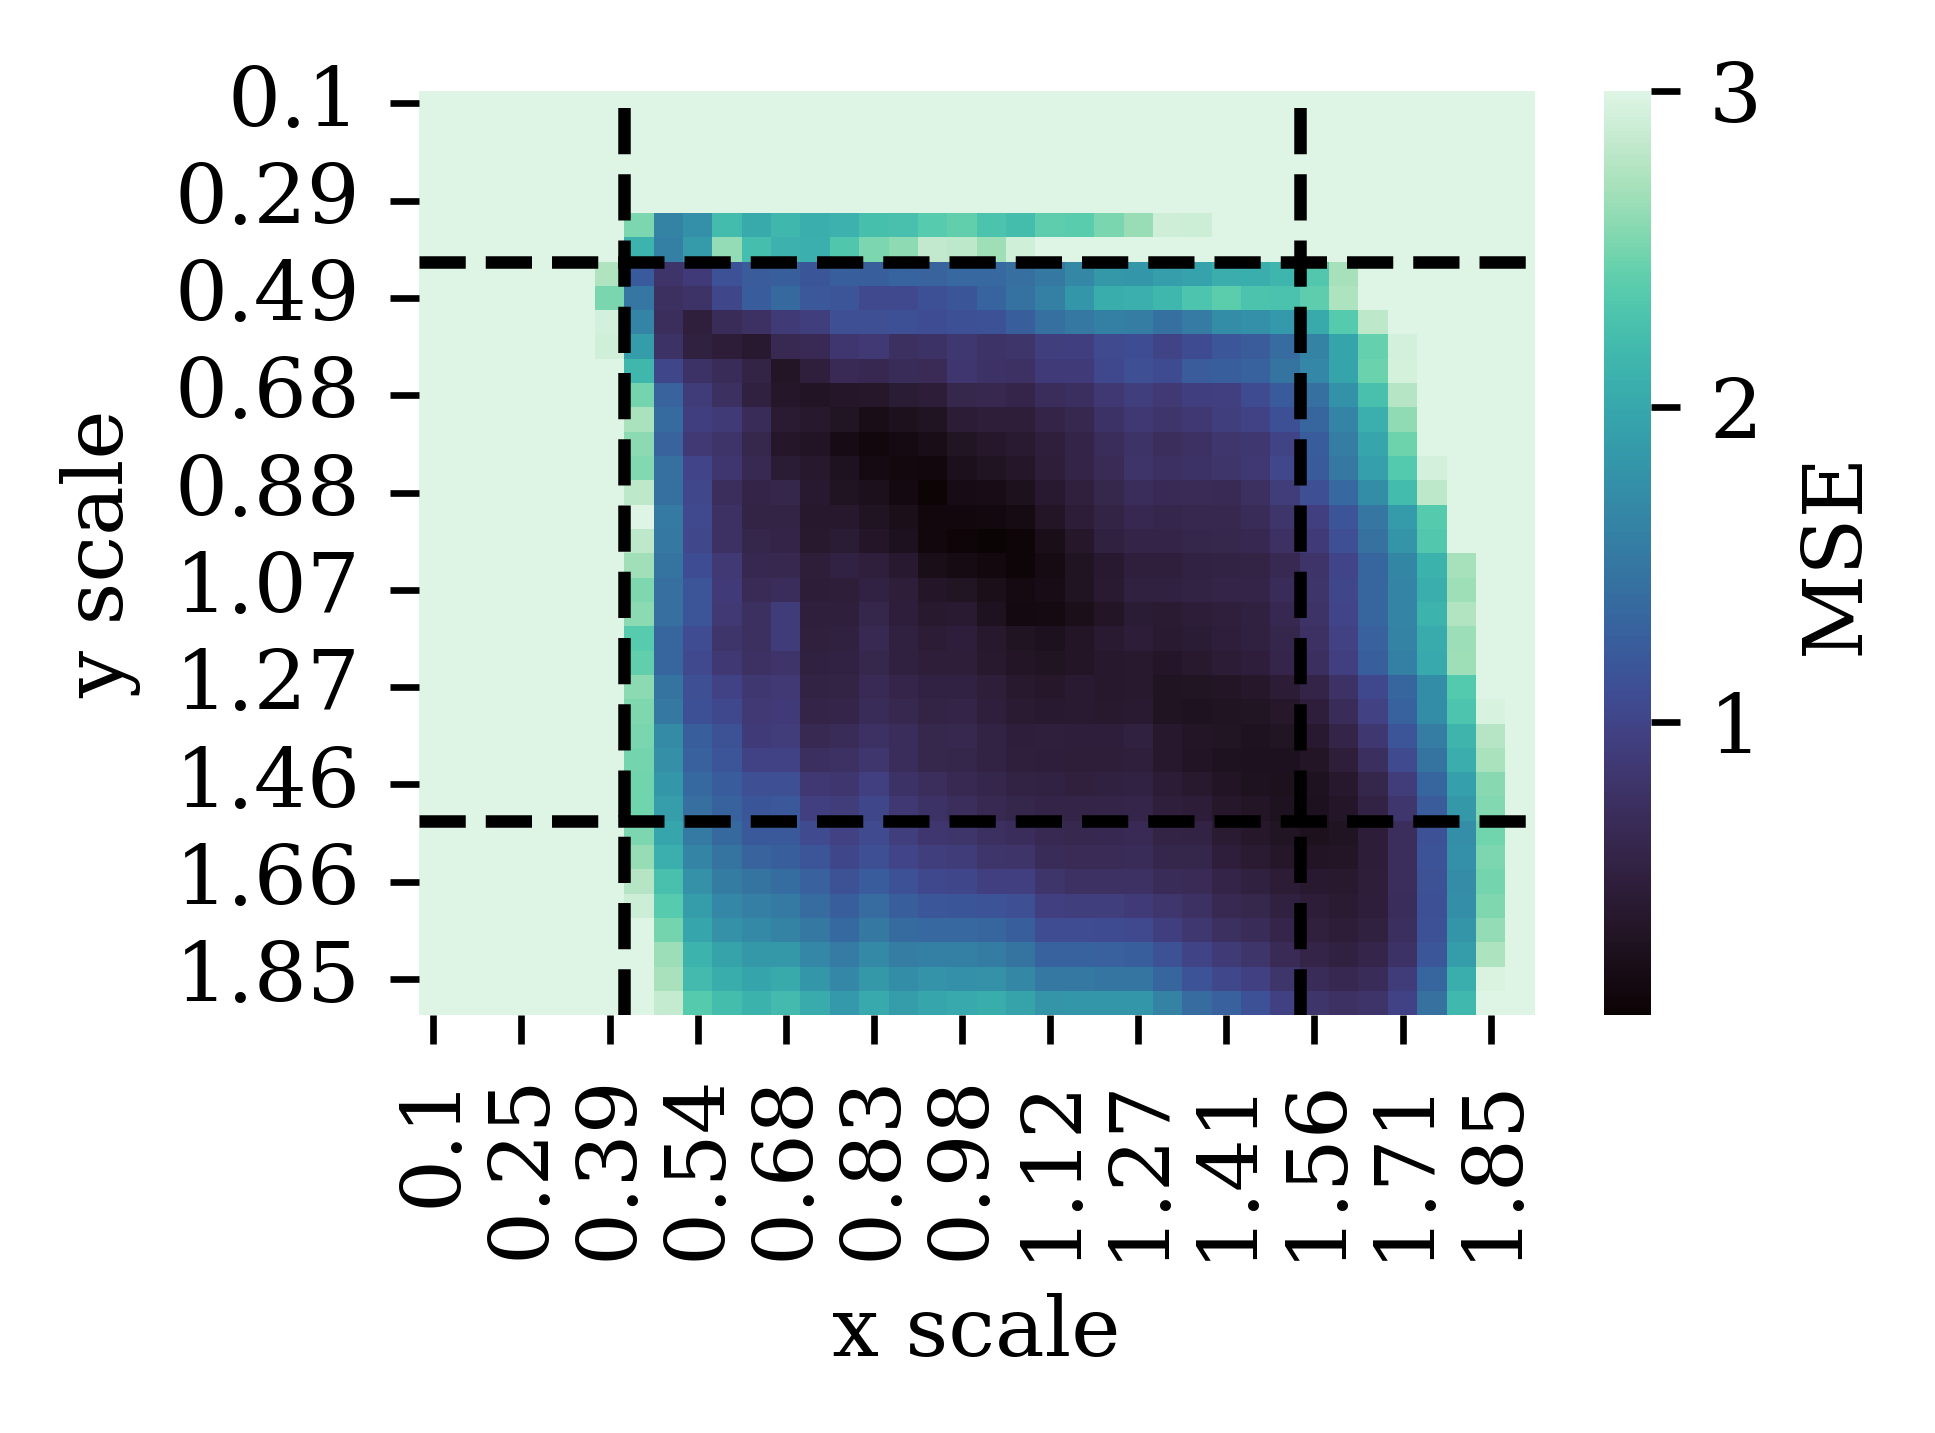

In [24]:
fig = figure(3, 2)
x1 = np.argmin(np.abs(scales - 0.45))
x2 = np.argmin(np.abs(scales - 1.55))
ax = sns.heatmap(all_mse_df, vmax=3, cmap='mako', cbar_kws={'label': 'MSE'})
ax.axhline(x1, color='k', linestyle='--')
ax.axhline(x2, color='k', linestyle='--')
ax.axvline(x1, color='k', linestyle='--')
ax.axvline(x2, color='k', linestyle='--')

## Run same analysis using the 25-dim bottleneck network

In [25]:
# path to the 25-dim bottleneck model
bottleneck_path = '/n/groups/datta/win/longtogeny/size_norm/models/bottleneck_param_scan_00/stage_01/cb6b4873-143b-4f64-aca0-92643c397a08/model.pt'
bottleneck_mdl = torch.jit.load(bottleneck_path, map_location='cuda' if torch.cuda.is_available() else "cpu").eval()

In [26]:
bottleneck_mses = []
for frame in tqdm(test_frame_array):
    batch = np.tile(frame, (len(scales), 1, 1, 1))
    comparison = predict(Session(frame[None]), bottleneck_mdl, batch_size=1, disable=True)
    mse = []
    for s in scales:
        resized = scale(torch.tensor(batch, dtype=torch.float32), torch.tensor([np.ones(len(scales)) * s, scales], dtype=torch.float32).T)
        resized_output = predict(Session(resized.squeeze().numpy()), bottleneck_mdl, batch_size=len(resized), disable=True)
        squared_error = np.square(resized_output - comparison)
        squared_error = np.mean(squared_error, axis=(1, 2))
        mse.append(squared_error)
    mse = np.array(mse)
    bottleneck_mses.append(mse)

bottleneck_mses = np.array(bottleneck_mses)

bottleneck_mse_df = pd.DataFrame(np.mean(bottleneck_mses, axis=0), index=np.round(scales, 2), columns=np.round(scales, 2)).T
bottleneck_mse_df.index.name = "y scale"
bottleneck_mse_df.columns.name = "x scale"

  0%|          | 0/8 [00:00<?, ?it/s]

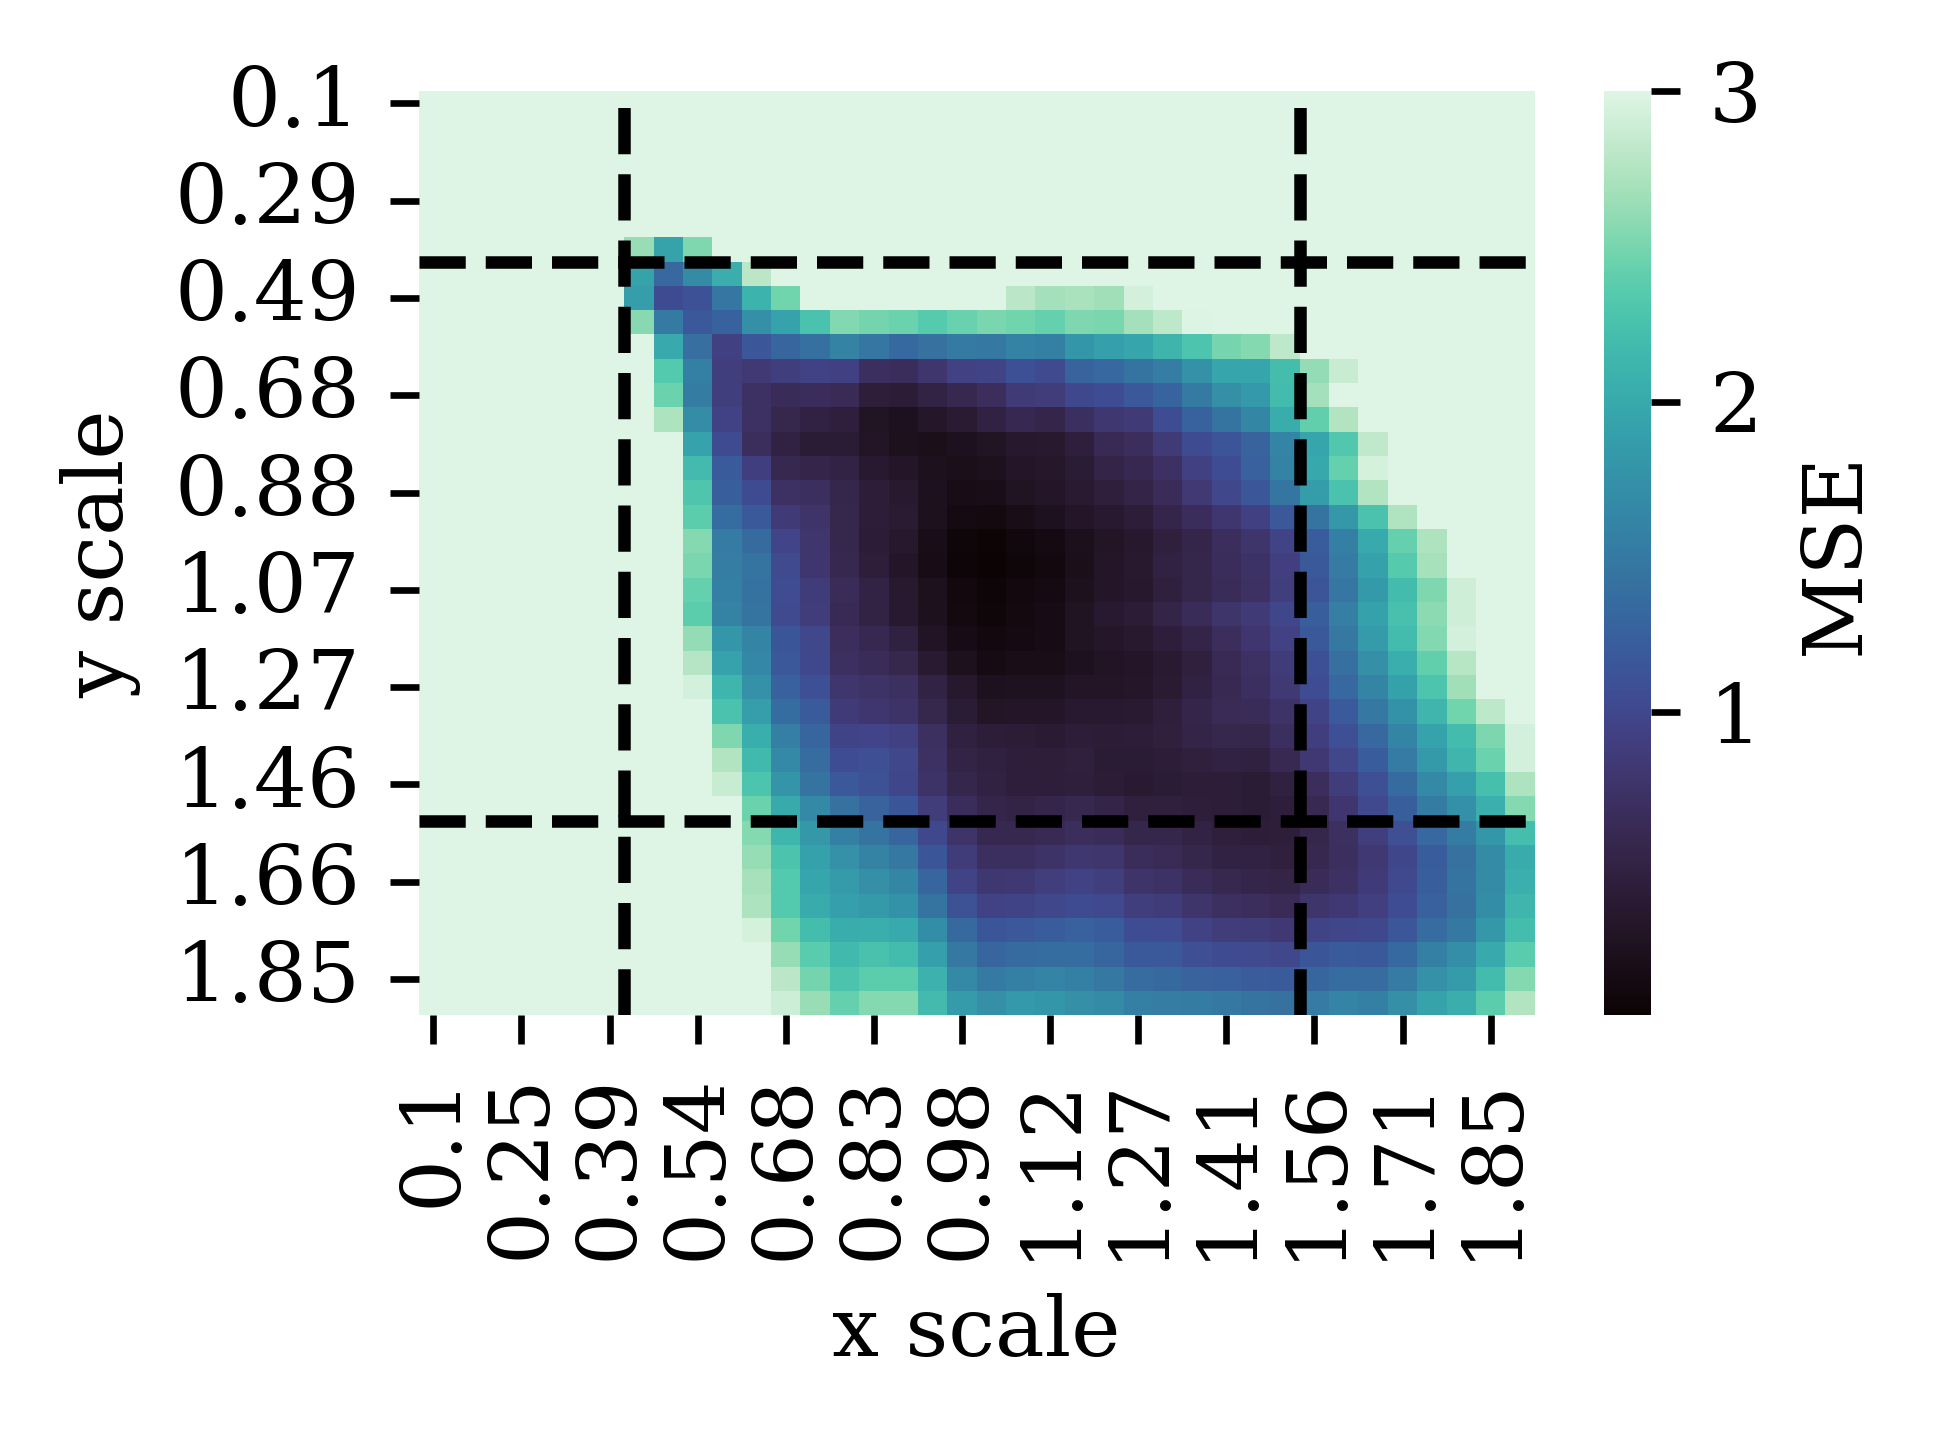

In [27]:
fig = figure(3, 2)
x1 = np.argmin(np.abs(scales - 0.45))
x2 = np.argmin(np.abs(scales - 1.55))
ax = sns.heatmap(bottleneck_mse_df, vmax=3, cmap='mako', cbar_kws={'label': 'MSE'})
ax.axhline(x1, color='k', linestyle='--')
ax.axhline(x2, color='k', linestyle='--')
ax.axvline(x1, color='k', linestyle='--')
ax.axvline(x2, color='k', linestyle='--')

## TPS warping

In [8]:
import joblib
import random
from kornia.geometry.transform import get_tps_transform, warp_image_tps

In [9]:
neutral_pose_warping_path = "/n/groups/datta/win/longtogeny/data/size_network/training_data/baseline-target-warp-points.p"

In [10]:
points = joblib.load(neutral_pose_warping_path)

In [23]:
def create_tps_kernels(source, target):
    source = (source / 80.0) - 0.5
    target = (target / 80.0) - 0.5
    return source, *get_tps_transform(target, source)


def select_tps_points(points, n, rng=None, device=torch.device("cpu")):
    if rng is None:
        rng = random
    # first, select random dict entry
    val = rng.choice(list(points.values()))
    # next, select a warping from list
    source, target = rng.choice(val)
    source = torch.tensor(source, dtype=torch.float32, device=device)
    target = torch.tensor(target, dtype=torch.float32, device=device)
    # expand source, kernel, affine, to batch size n
    source = source.expand(n, *source.shape)
    target = target.expand(n, *target.shape)
    # add some jitter to the target points
    target = target + torch.randn_like(target) * 0.1
    source, kernel, affine = create_tps_kernels(source, target)
    return source, kernel, affine, (target / 80.0) - 0.5

In [24]:
rng = random.Random(42)
data = torch.tensor(test_frame_array, dtype=torch.float32, device=device).unsqueeze(1)
params = select_tps_points(points, len(data), rng=rng, device=device)

In [25]:
warped_data = warp_image_tps(data, *params[:-1])

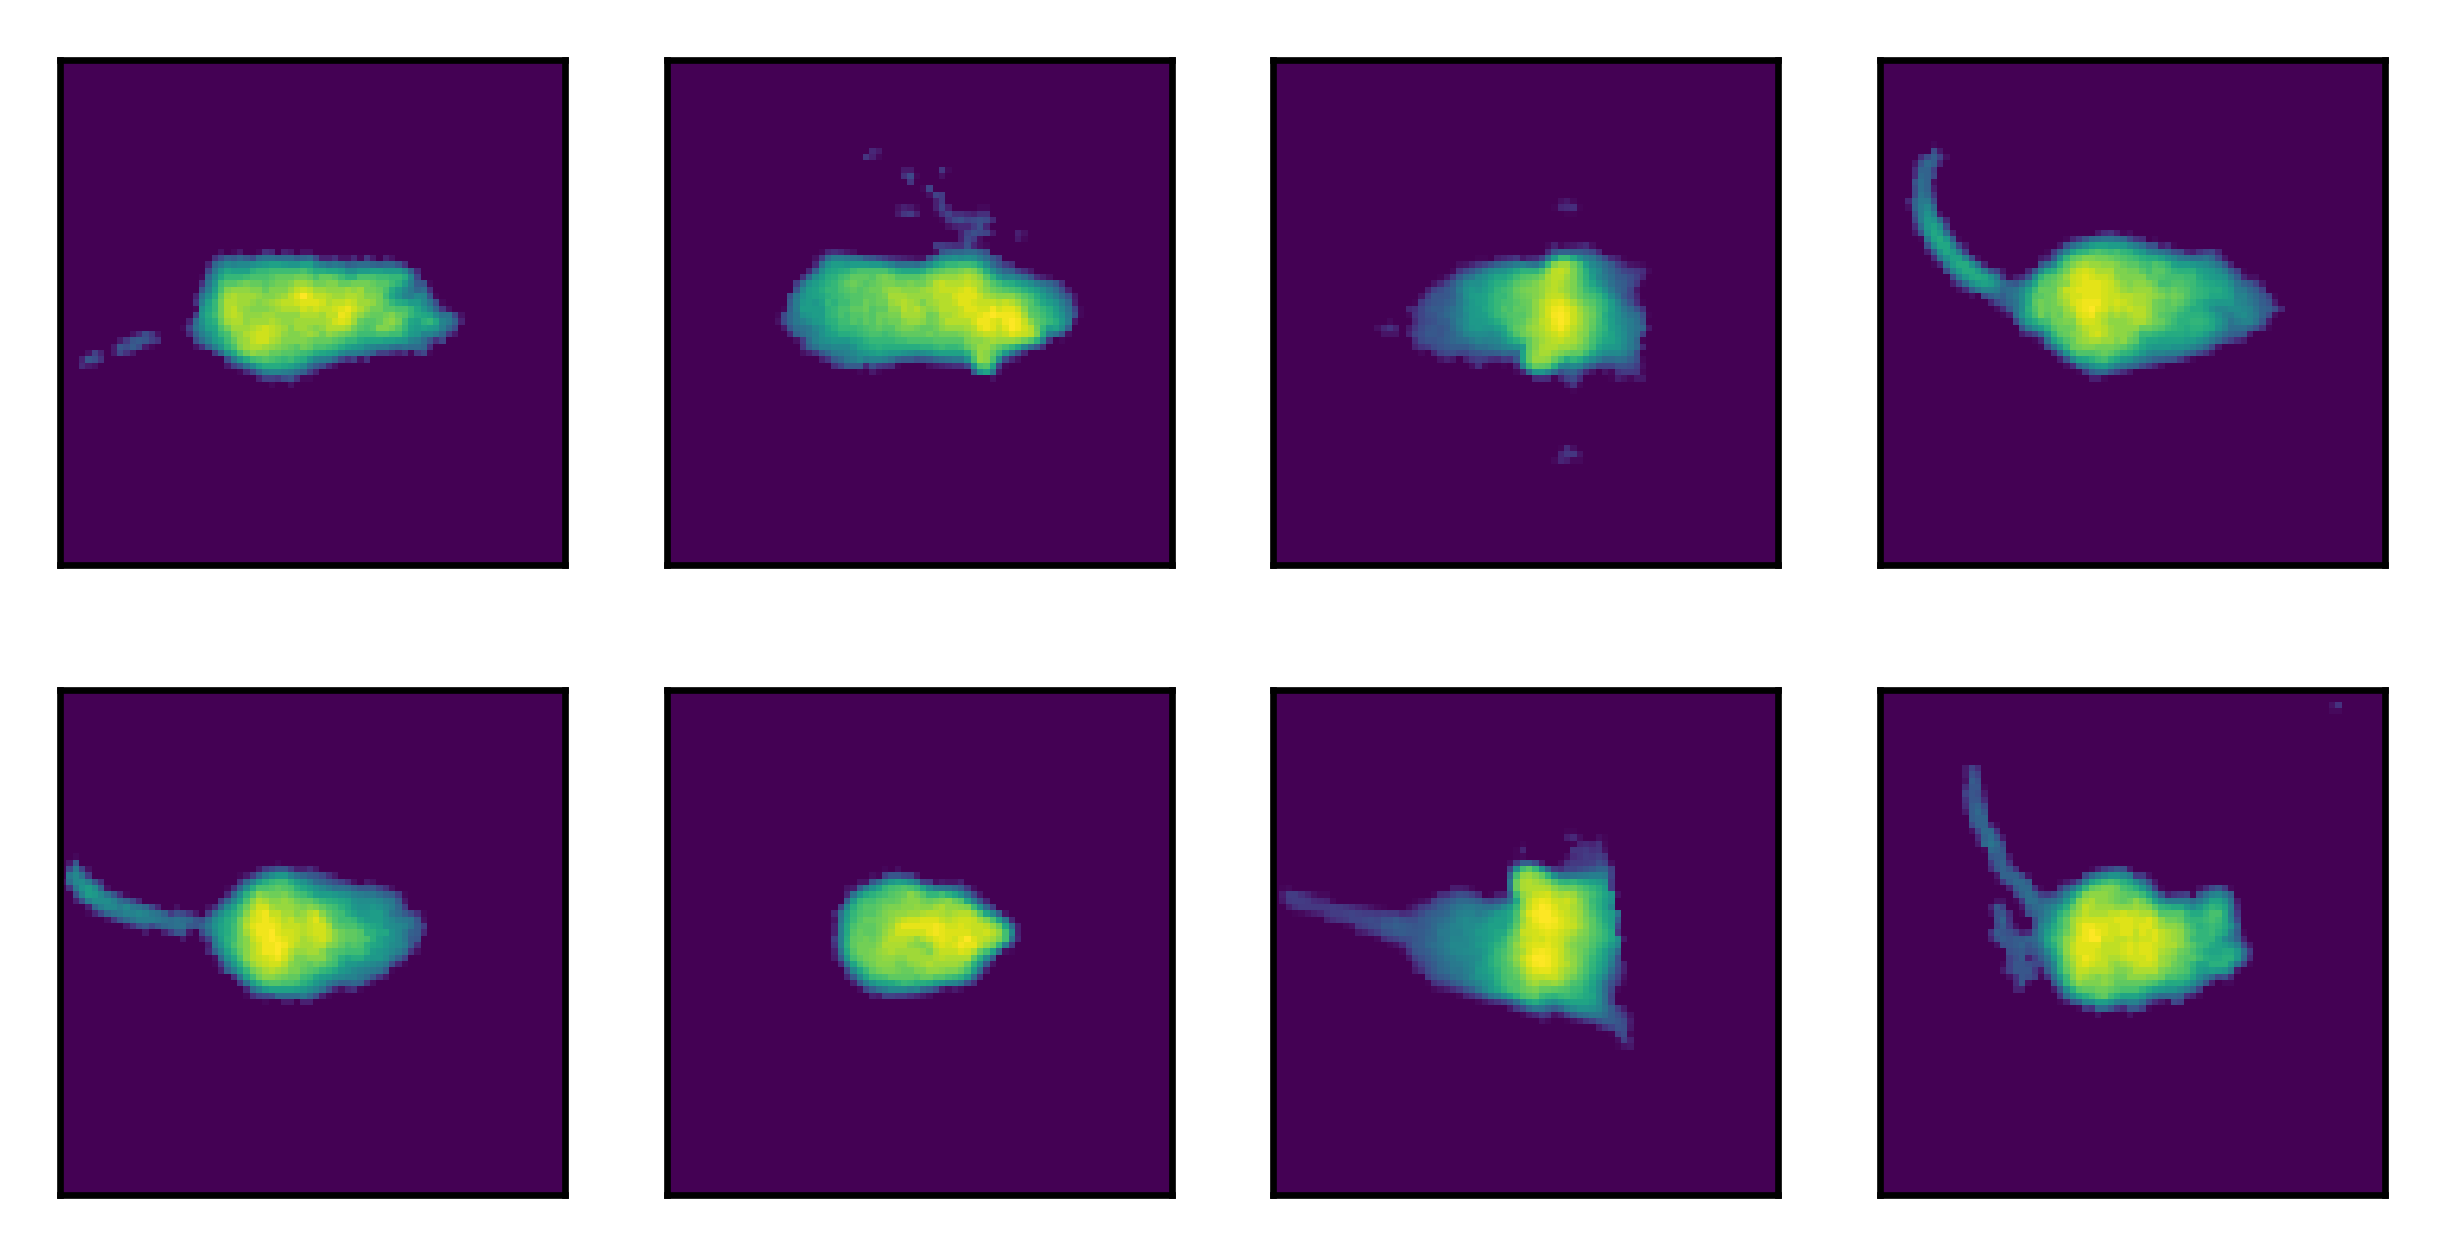

In [26]:
fig, ax = plt.subplots(2, 4, figsize=(5, 2.5))
for a, im in zip(ax.flat, data.squeeze()):
    a.imshow(im.cpu())
    a.set(xticks=[], yticks=[])

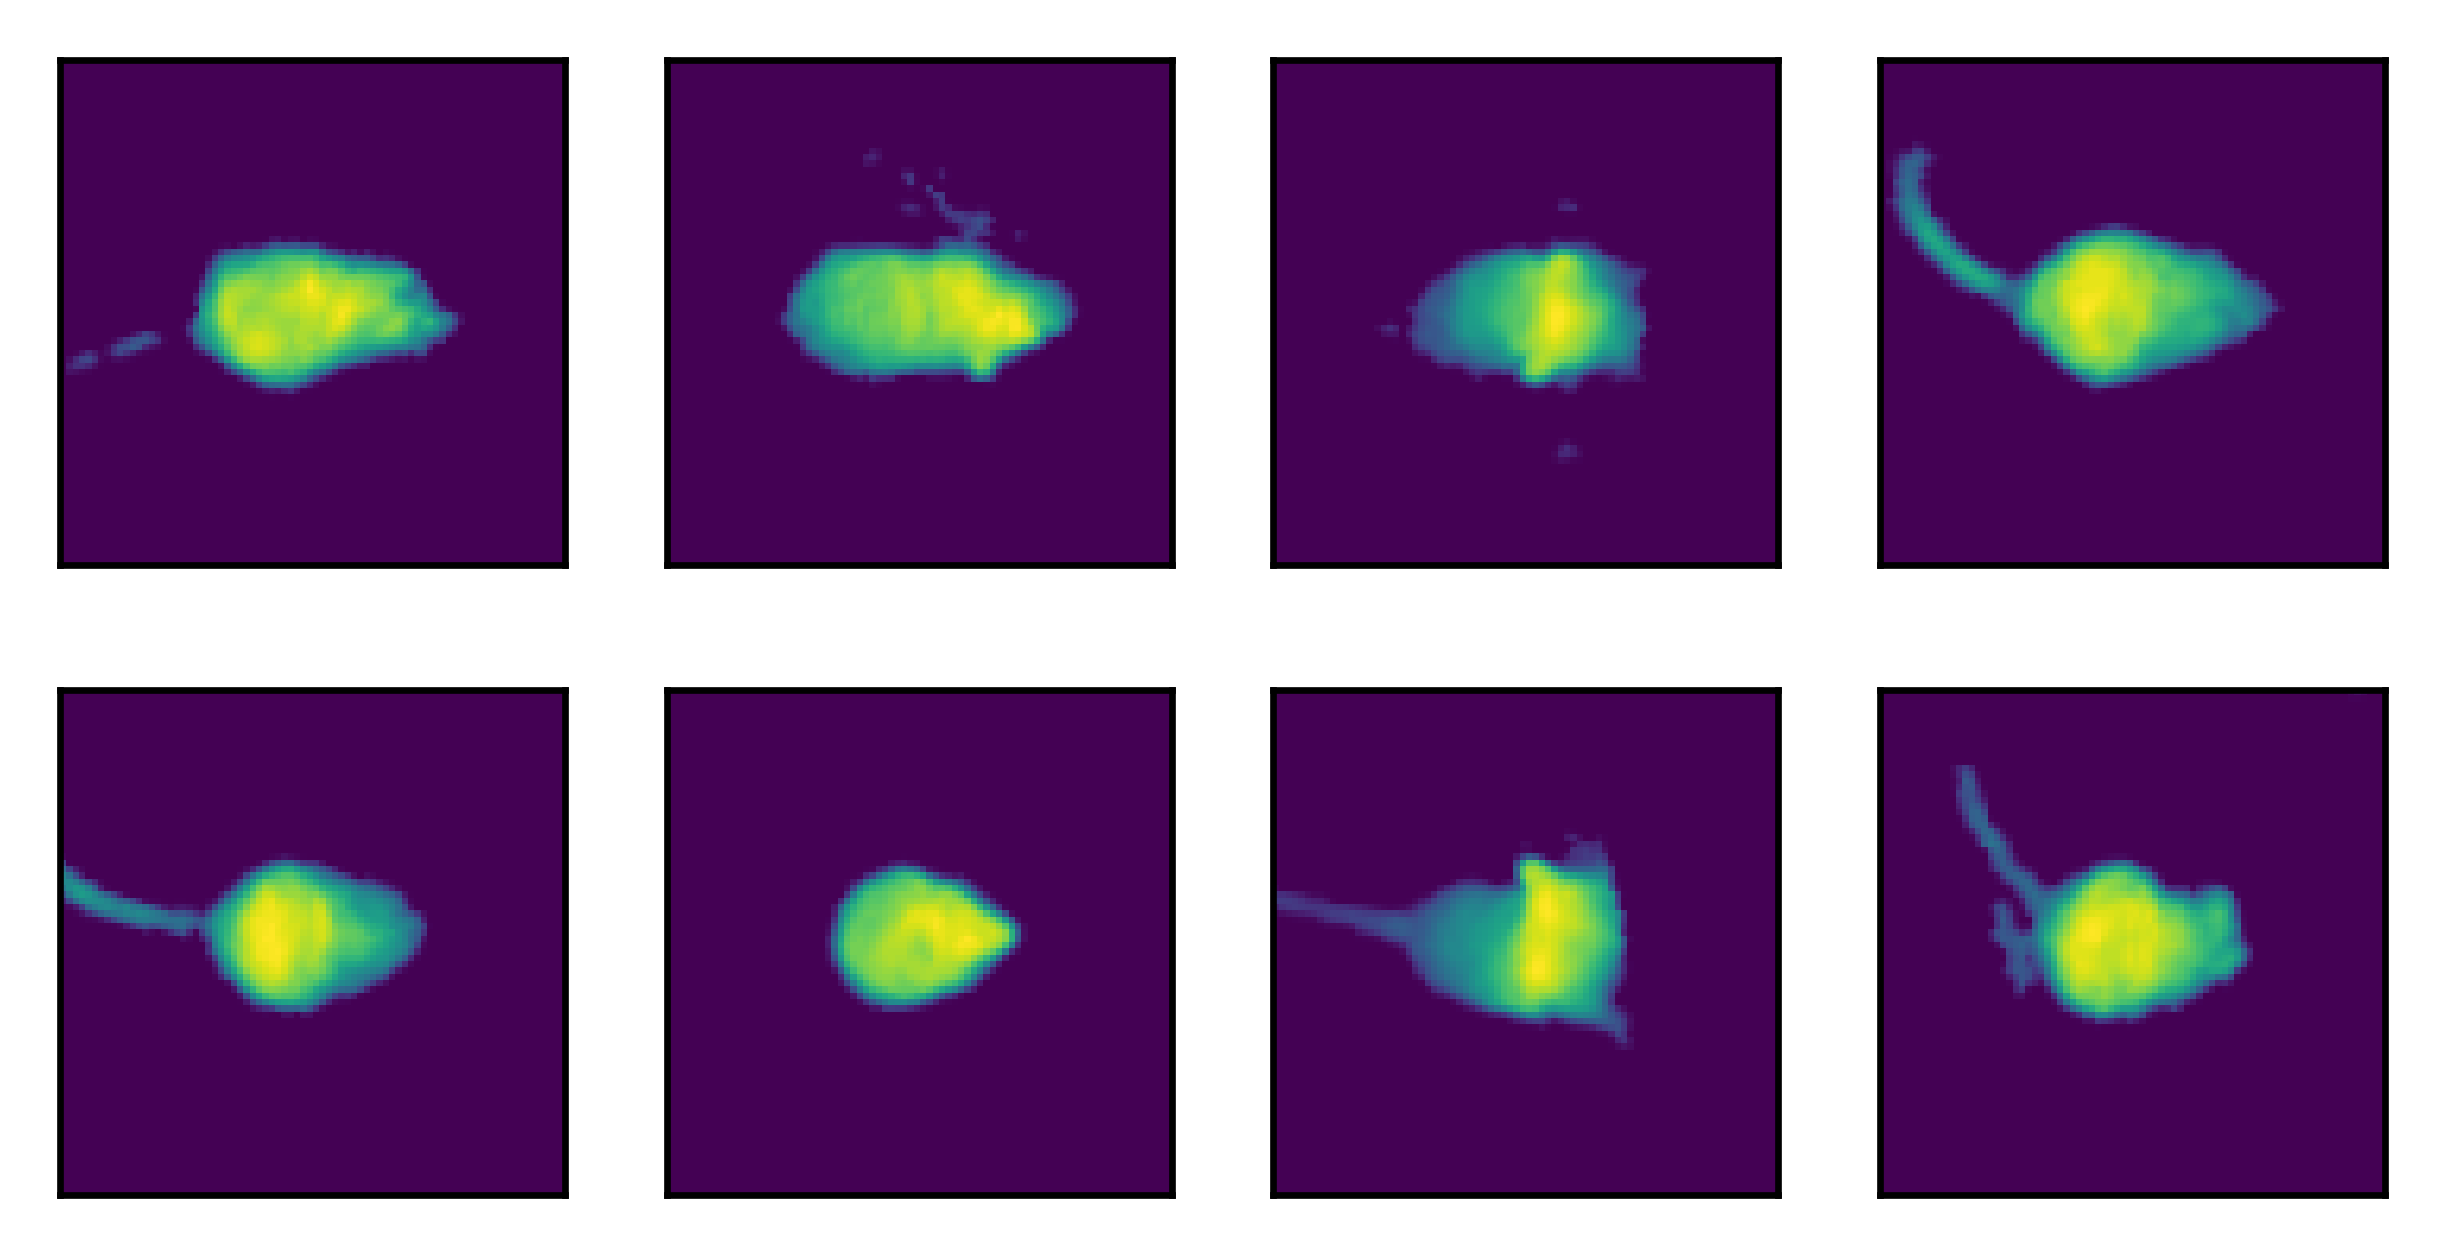

In [27]:
fig, ax = plt.subplots(2, 4, figsize=(5, 2.5))
for a, im in zip(ax.flat, warped_data.squeeze()):
    a.imshow(im.cpu())
    a.set(xticks=[], yticks=[])

In [28]:
params[0].shape

torch.Size([8, 14, 2])

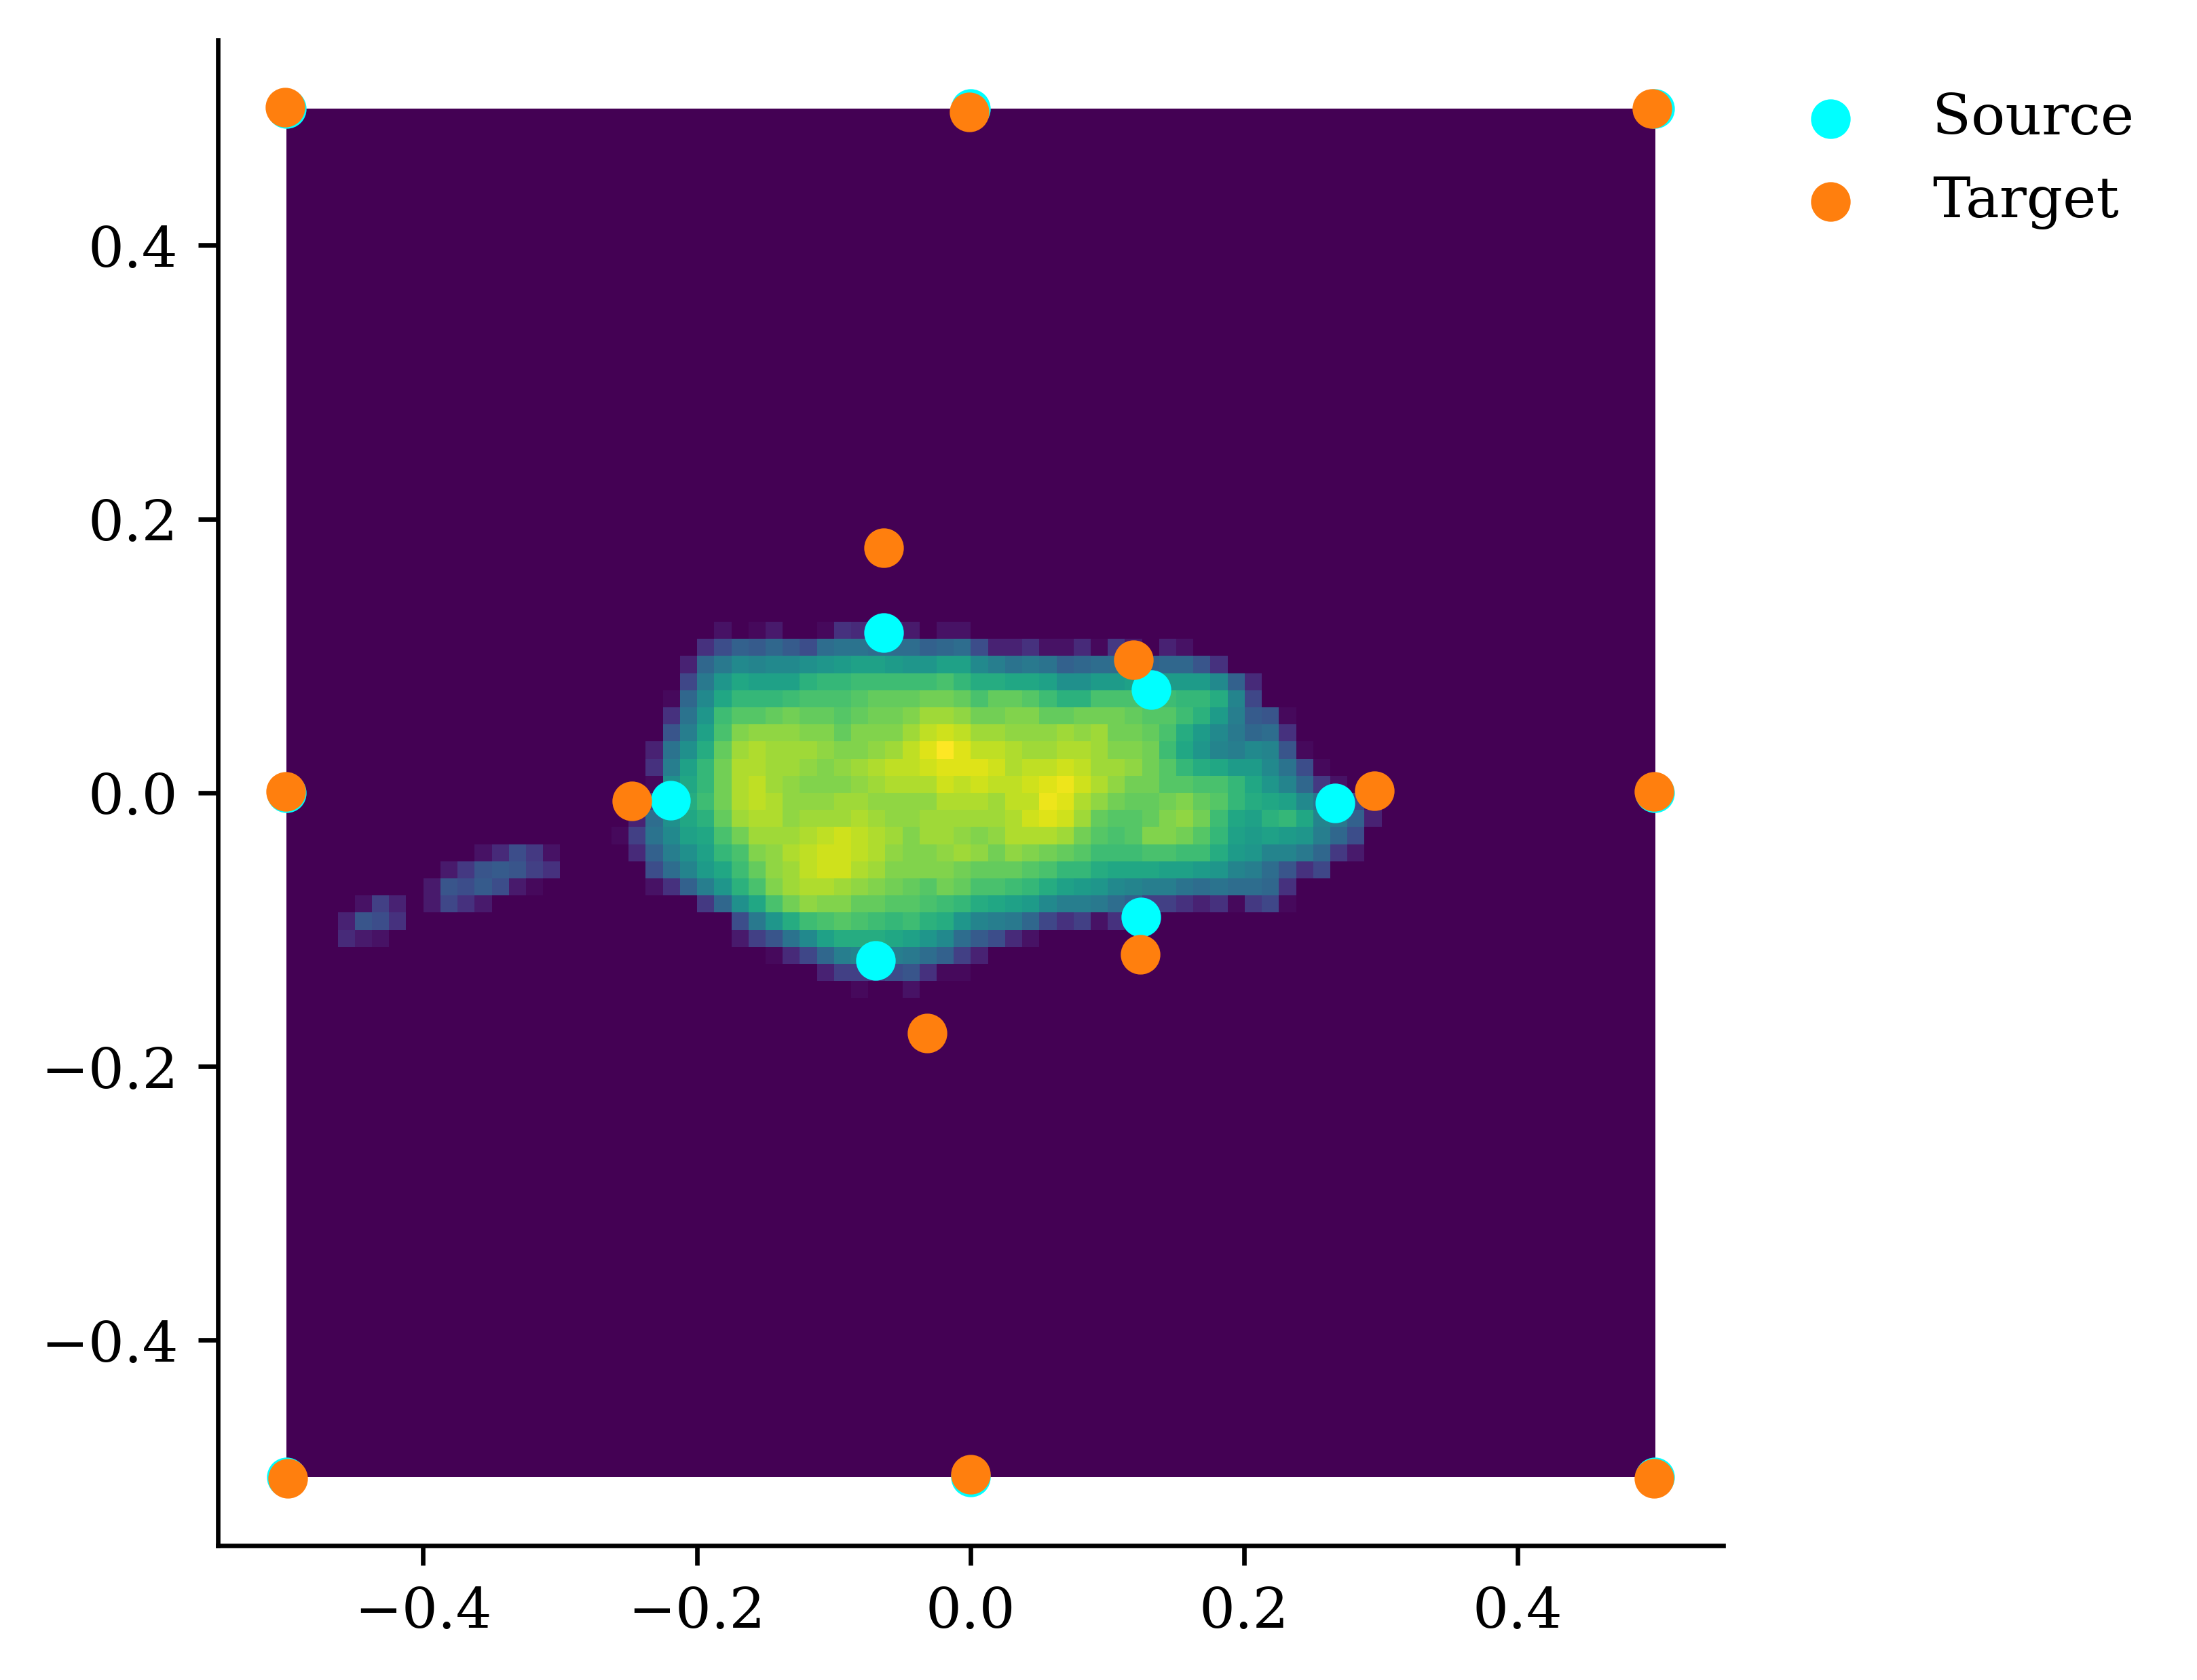

In [46]:
idx = 0
plt.imshow(data[idx].squeeze().cpu(), extent=(-0.5, 0.5, -0.5, 0.5))
plt.scatter(*(params[0][idx].T).cpu(), c='cyan', label="Source")
plt.scatter(*(params[-1][idx].T).cpu(), c='C1', label="Target")
sns.despine()
plt.xlim(-0.55, 0.55)
plt.ylim(-0.55, 0.55)
legend()

In [47]:
comparison = predict(Session(data.cpu().numpy().squeeze()), mdl, batch_size=len(data))
transformed = predict(Session(warped_data.cpu().numpy().squeeze()), mdl, batch_size=len(data))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

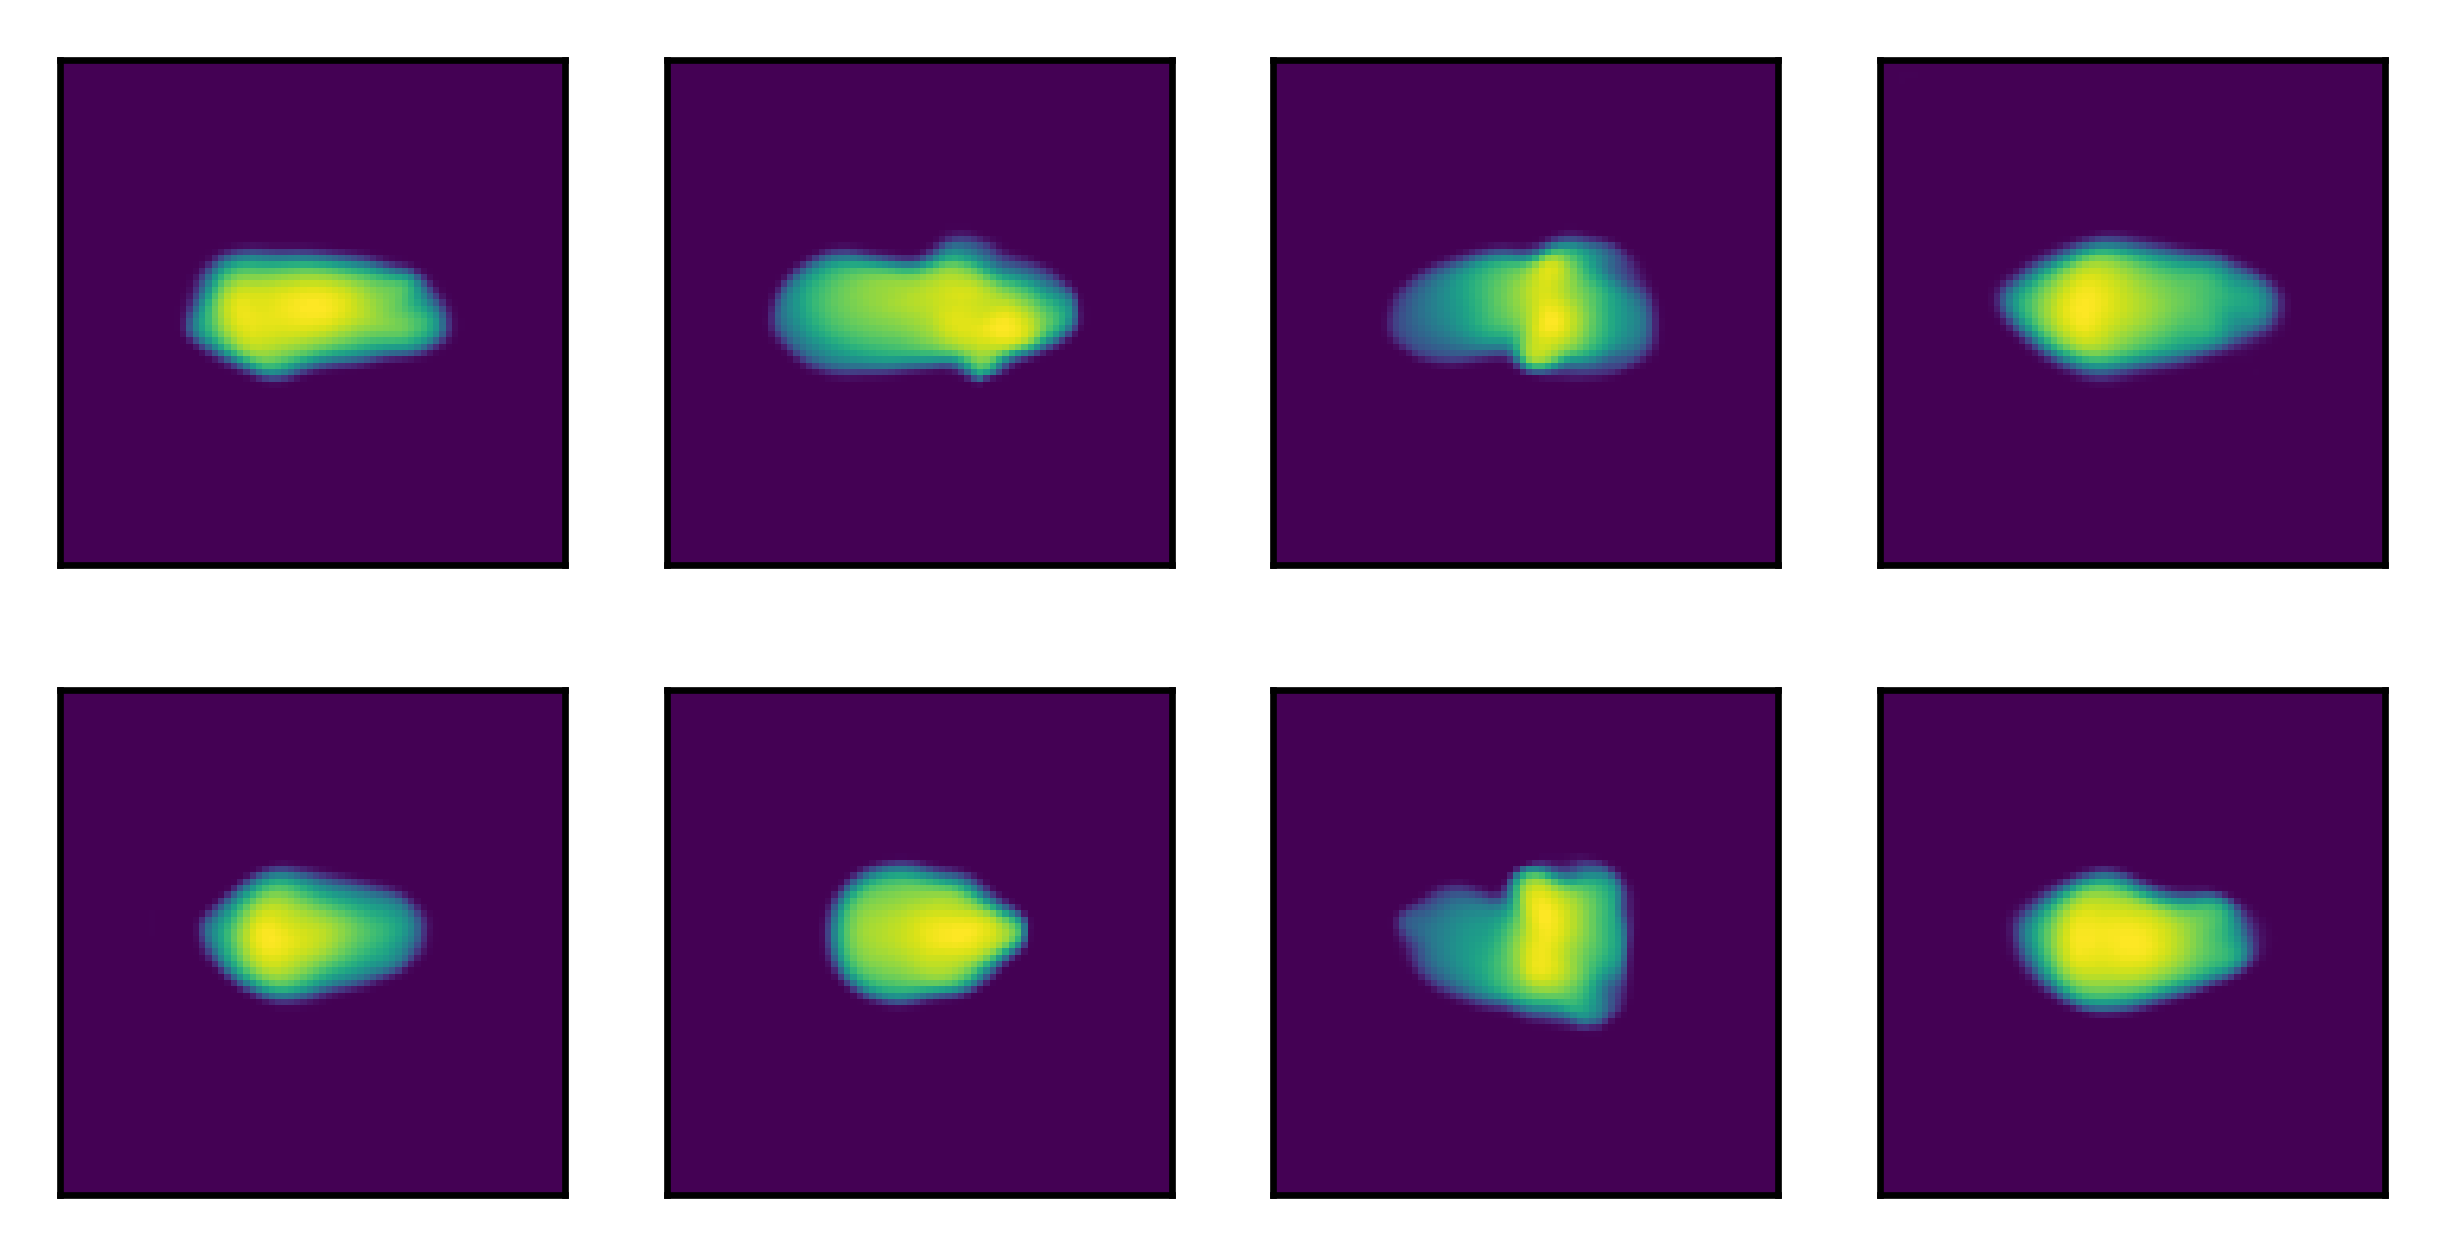

In [48]:
fig, ax = plt.subplots(2, 4, figsize=(5, 2.5))
for a, im in zip(ax.flat, comparison.squeeze()):
    a.imshow(im)
    a.set(xticks=[], yticks=[])

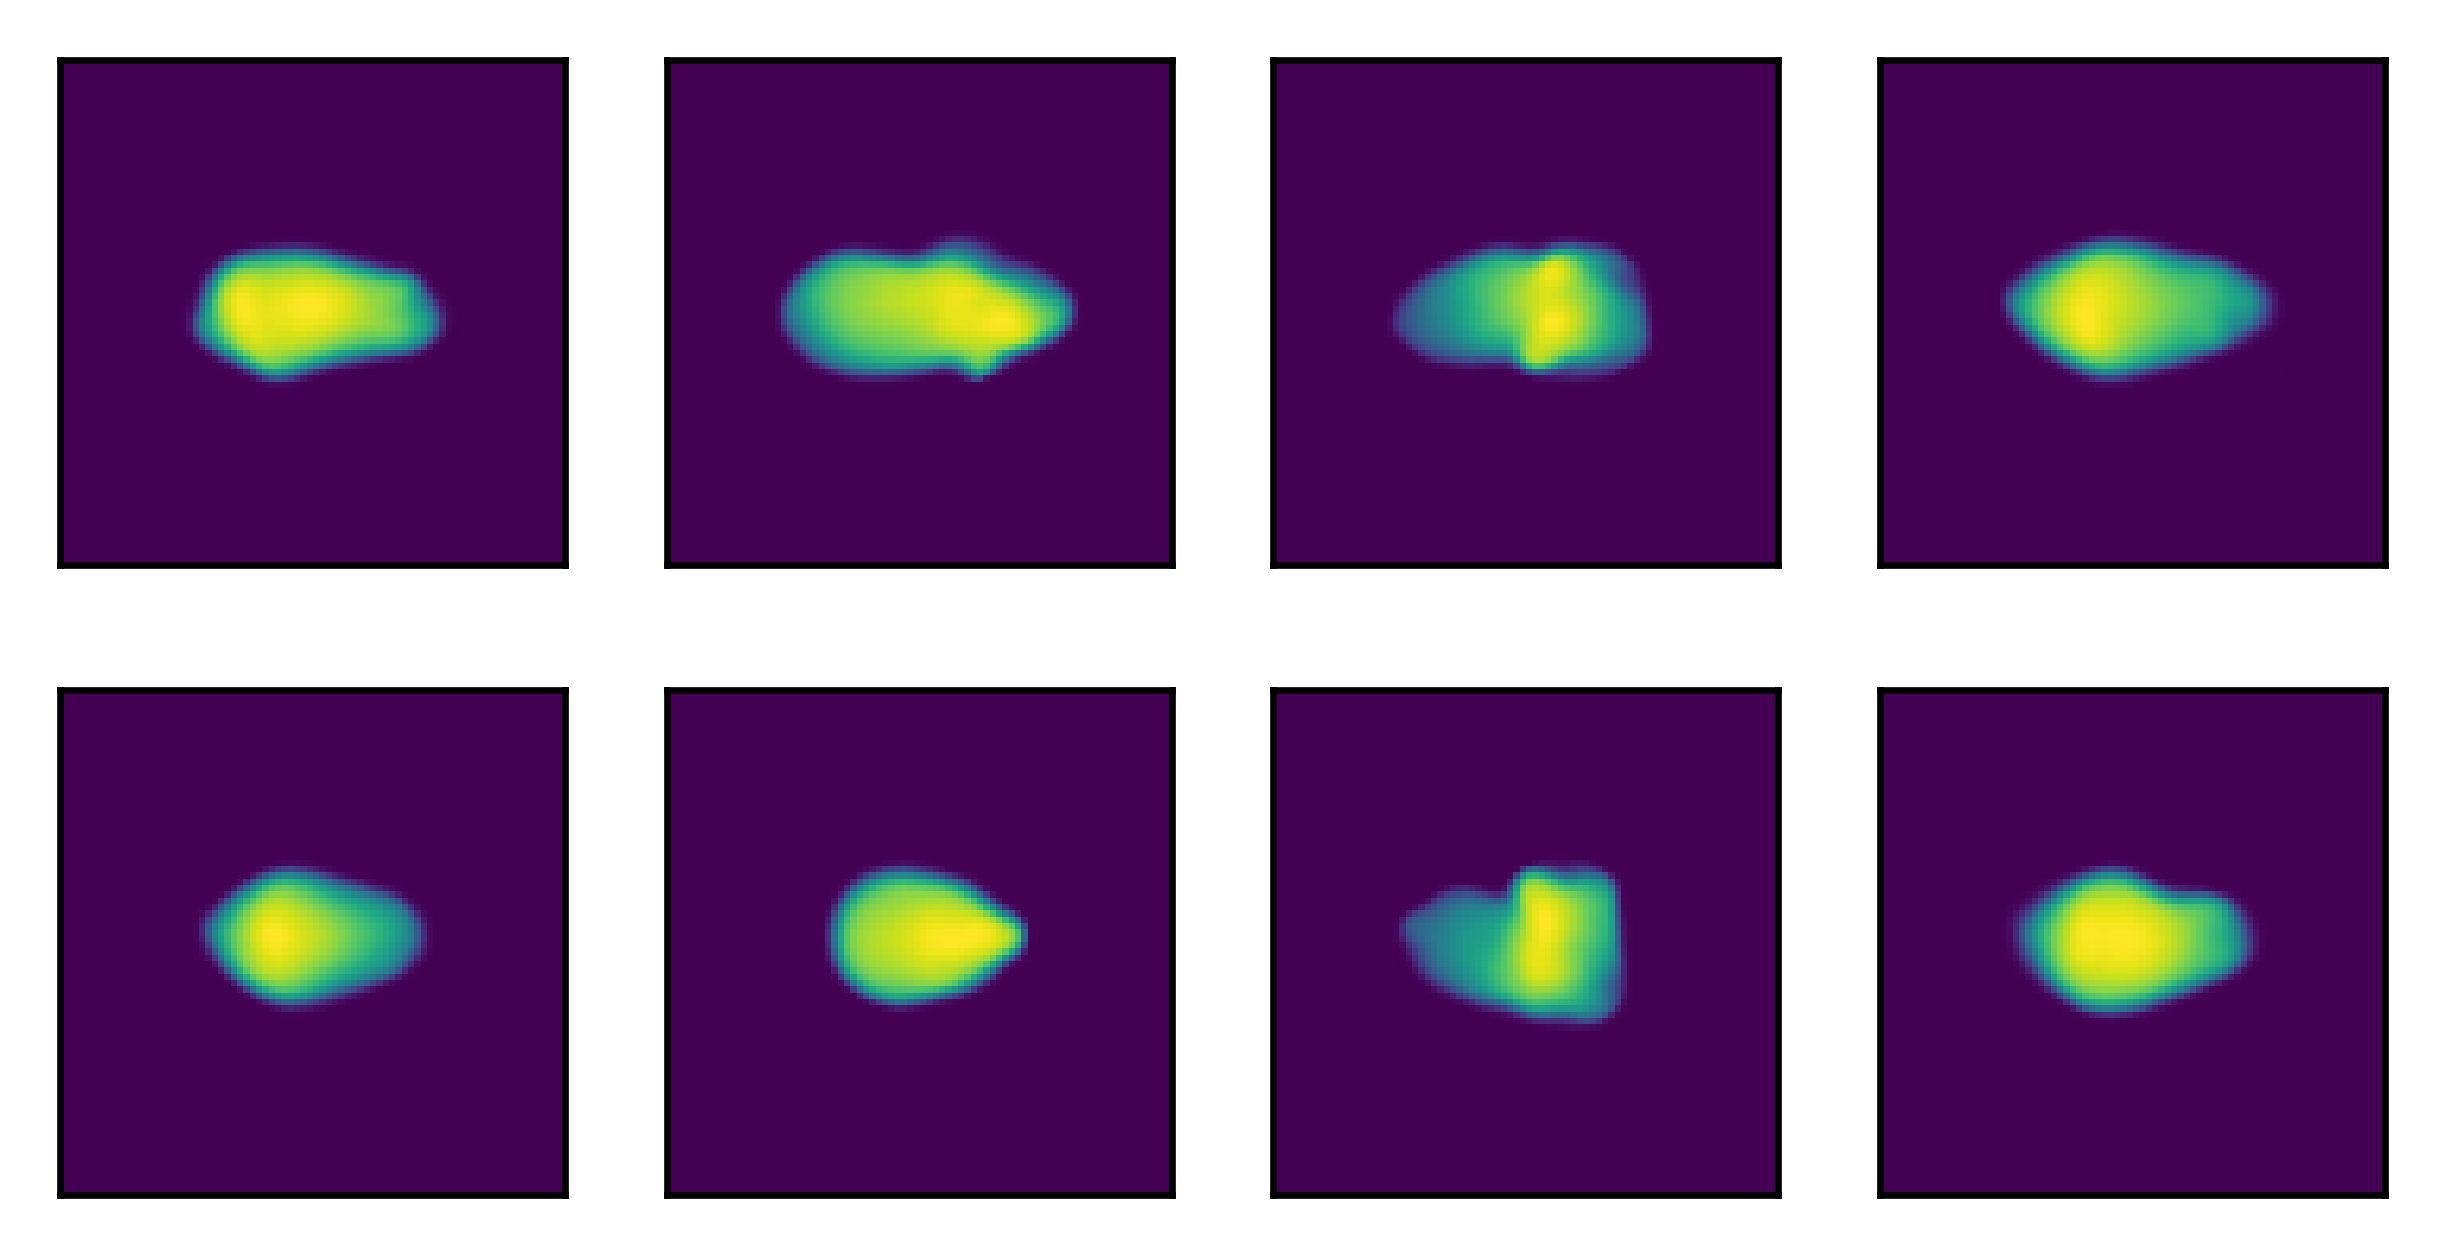

In [49]:
fig, ax = plt.subplots(2, 4, figsize=(5, 2.5))
for a, im in zip(ax.flat, transformed.squeeze()):
    a.imshow(im)
    a.set(xticks=[], yticks=[])

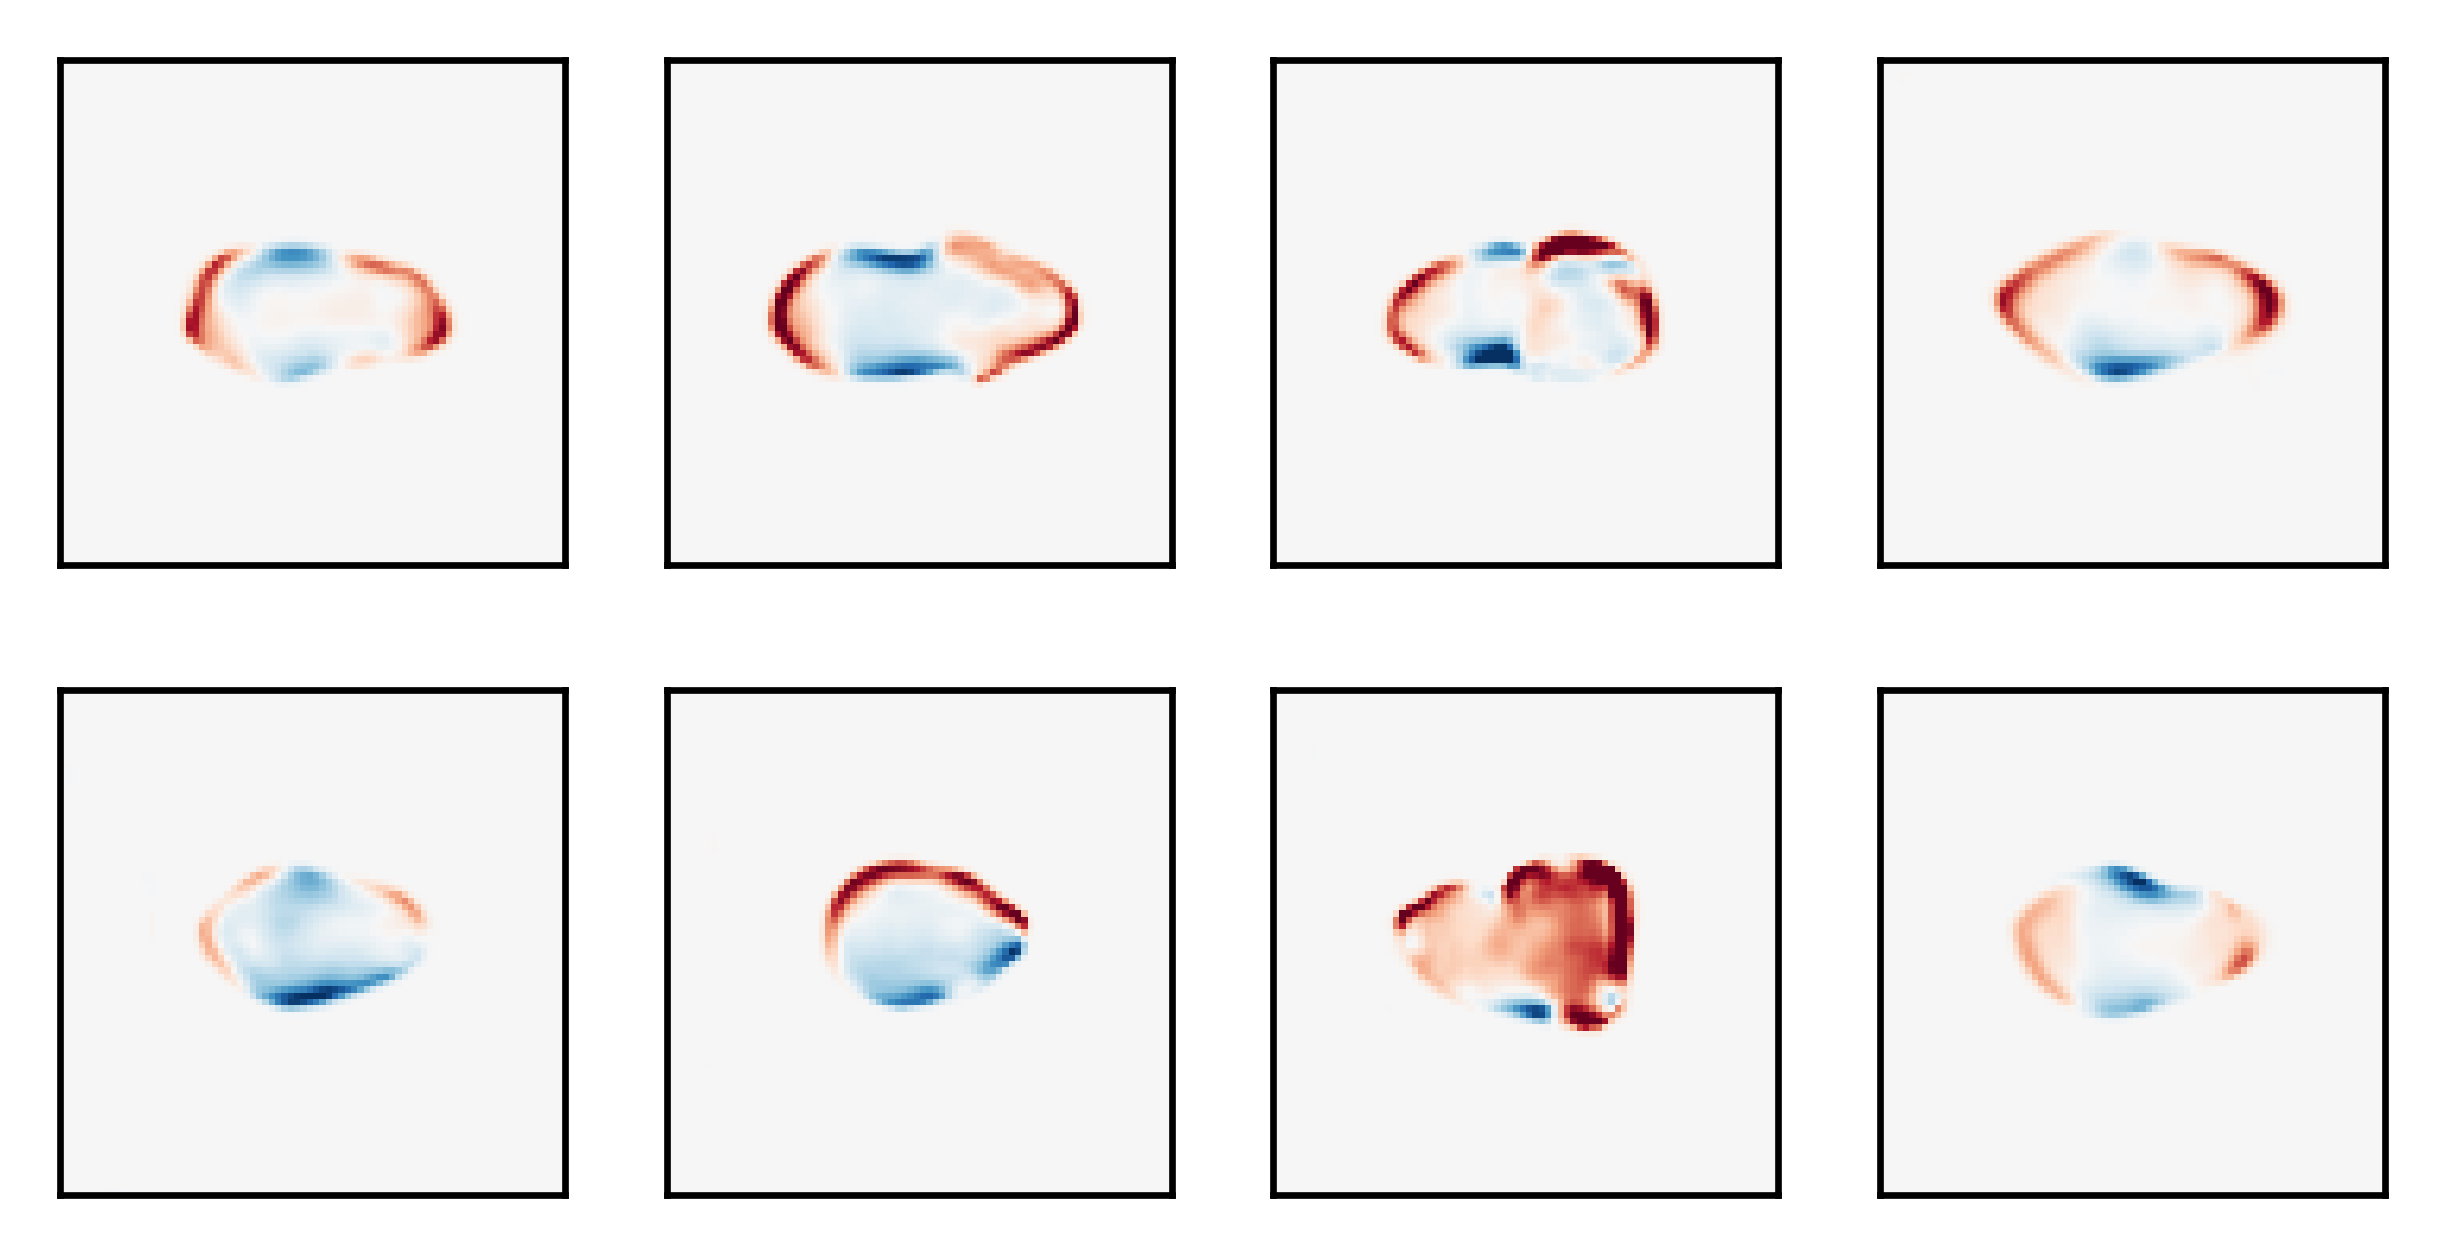

In [51]:
fig, ax = plt.subplots(2, 4, figsize=(5, 2.5))
for a, im in zip(ax.flat, (comparison - transformed).squeeze()):
    a.imshow(im, cmap='RdBu_r', vmin=-10, vmax=10)
    a.set(xticks=[], yticks=[])